In [1]:
import openai
from openai.types import Completion, CompletionChoice, CompletionUsage
import os
import requests
from dotenv import load_dotenv
from scipy.optimize import minimize, Bounds, NonlinearConstraint
from functools import partial, wraps 
import time
load_dotenv("/Users/gabriellelittlefair/Documents/GitHub/MSc Project/DSL/hidden.env")
%reload_ext autoreload         
from Setup_Functions import *
from Class_Structures import *
from Region import * 
from Individual import * 

from InterObject import * 
from Global import * 


In [83]:
## Set up the API calls 
api_key = os.getenv('OPENAI_API_KEY')
client = openai.Client(api_key=api_key)
url = 'https://api.openai.com/v1/chat/completions'
headers = {
    'Authorization': f'Bearer {api_key}', 
    'Content-Type': 'application/json',
        }

## Read in all of the files to be used in the task
file_path1 = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/BlankConstraints/Setup_Functions.py'
with open(file_path1, 'r') as file:
    file_contents1 = file.read()

file_path2 = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/BlankConstraints/Individual.py'
with open(file_path2, 'r') as file:
    file_contents2 = file.read()

file_path3 = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/BlankConstraints/InterObject.py'
with open(file_path3, 'r') as file:
    file_contents3 = file.read()

file_path4 = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/BlankConstraints/Tertiary.py'
with open(file_path4, 'r') as file:
    file_contents4 = file.read()

def remove_identical_lines(function):
    lines = function.split("\n")
    unique_lines = []
    for i in range(len(lines)):

        line = lines[i]
        if line not in unique_lines: 
            unique_lines.append(line)
    return("\n").join(unique_lines)

def check_and_call(func_name, *args, **kwargs):
    """
    Calls the function with the given name if it exists in the global namespace.
    Returns the function's result or 0 if the function does not exist.
    """
    if func_name in globals() and callable(globals()[func_name]):
        return globals()[func_name](*args, **kwargs)
    else:
        return 0

def check_calls_decorator(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        return result
    return wrapper

# Set up the Room (all dimensions + fixed features)

### Set the Scene Descriptor

In [84]:
start_time = time.time() # Start the time
scene_descriptor = "An office for a bestselling writer in New York who likes to write Fantasy books."

### Run the room set up calls (LangPrompt1, Prompt1)

In [85]:
lang_prompt1 = """ I am designing the layout for a """ +  scene_descriptor + """. Give me the dimensions of the room, as well as the number of windows, 
doors, and sockets (there can be no windows or no sockets if appropriate). For each of these, tell me the dimensions in meters, which wall it should be on, as well as where on the wall it should 
be (a value between 0 and 1 determining how far along the wall it should be). Here is an example for a room and window set up: 
{Room: width = 5, length = 6}, {Object type: window, width = 1, length = 0.1, wall = south, position = 3}. The windows and doors should all 
have length 0.1. Ensure that every object has dimensions, position, and wall. No other text please. Just the list with no commentary or explanation.
"""

lang1output = client.chat.completions.create(
    model="gpt-4o",
    messages=[{"role": "user", "content": lang_prompt1}],
    max_tokens=500
)
objects = lang1output.choices[0].message.content.split("}, {")

prompt1 = """The functions in the following file are used to create a room and out objects in it: """ + file_contents1 + """. The room is described 
as """ +  scene_descriptor + """. For every element in this list, """ + str(objects) + """, translate it into a function call using the file attached.
For example, given the room descriptor 'a small kitchen' as well as the list: {Room: width = 5, length = 6}, 
{Object type: window, Number: 1, width = 1, length = 0.1, wall = south, position = 0.3}, the output would be:
kitchen = create_room(5, 6), create_fixed_object(kitchen, 'window', 1, 0.1, 'south', position = 0.3). Return only the python script. 
No other text. Please ensure the correct number of inputs are given for each function."""

# Define the request payload
data = {
    "model": "gpt-4",
    "messages": [
        {"role": "user", "content": prompt1}
    ]
}

# Make the API call
response1 = requests.post(url, headers=headers, json=data)  
# Check the response
if response1.status_code == 200:
    response_data1 = response1.json()
    if "```python" in response_data1['choices'][0]['message']['content']:
        response1 = (response_data1['choices'][0]['message']['content'].split("```python")[1]).split("```")[0]
    elif "```" in response_data1['choices'][0]['message']['content']:
        response1 = (response_data1['choices'][0]['message']['content'].split("```")[1]).split("```")[0]
    else: 
        response1 = response_data1['choices'][0]['message']['content']
else:
    print('Failed to get a response')
    print(response1.text)

## Account for any additional function calls (of other functions) by only taking the lines in the code that are relevant to the task   
lines = response1.split("\n")
response1 = [i for i in lines if 'create_room' in i]
## If the room is not defined properly, correct it
for line in response1: 
    if '=' not in line: 
        response1 = ['room = ' + line]
for line in lines[1:]: 
    if "create_fixed_object" in line: 
        response1.append(line)

response1 = ("\n").join(response1)

response1 = """ 
room = create_room(4, 5)
create_fixed_object(room, 'window', 1, 0.1, 'north', 0.3)
create_fixed_object(room, 'window', 1, 0.1, 'south', 0.5)
create_fixed_object(room, 'door', 0.9, 0.1, 'west', 0.1)
create_fixed_object(room, 'socket', 0.15, 0.1, 'east', 0.2)
create_fixed_object(room, 'socket', 0.15, 0.1, 'north', 0.9)
create_fixed_object(room, 'socket', 0.15, 0.1, 'west', 0.7)
"""

width = (response1.split("create_room("))[1].split(",")[0]
length = (response1.split("create_room("))[1].split(",")[1].split(")")[0]
room_name = (response1.split("create_room("))[0].split("=")[0].strip()

lang_prompt2 = """ I am designing the layout of a """ + scene_descriptor + " that is " + width + "m x " + length + """m. Interior designers
suggest that a good layout will have different regions in the room for different functions. What regions should I use, and how many regions 
(minimum is 1 region - small rooms, e.g. 3x3, 2x3, etc, should only have 1 region, small medium sized rooms will have 2, 3x4, 4x3, 4x4, medium will have 3, etc) 
should there be based on the description, as well as the size of the room. Make sure to not add too many regions as this causes overcrowding 
(very few rooms will have more than 3/4 regions). Return this as a simple bullet list of regions to 
include. Return these in list of priority order. Do NOT add too many regions.
Only return the list of regions. No other information please."""

lang2output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt2}],
        max_tokens=500
    )

prompt2 = "Given the room name: " + room_name + ", and the regions: " + lang2output.choices[0].message.content + """, using the function region_setup defined below, 
initialise each region. For example 'eating region' might output 'region_setup(kitchen, 'eating', 0). Where possible the region name ('eating') should be 
only one word. No other text please, 
only the python script. Don't include the function in the output. The function is: 
def region_setup(room_name, name, index):
    '''A function that initialises the regions in a room randomly.
        Inputs:
        room_name: Room obj (this should be the name of the room)
        name: str, the name of the region e.g 'sleeping'
        index: int, the index of the region (0, 1, 2, ...). First one must be 0, and the rest must be in order.
    '''
    return
"""
# Define the request payload
data = {
    "model": "gpt-4",
    "messages": [
            {"role": "user", "content": prompt2}
            ]
    }
    
# Make the API call
response2 = requests.post(url, headers=headers, json=data)  
# Check the response
if response2.status_code == 200:
    response_data2 = response2.json()
    if "```python" in response_data2['choices'][0]['message']['content']:
        response2 = (response_data2['choices'][0]['message']['content'].split("```python")[1]).split("```")[0]
    else: 
        response2 = response_data2['choices'][0]['message']['content']
        
    global_context = globals().copy()
    local_context = {}  
    exec(response1 + "\n" + response2.replace("'" + room_name + "'", room_name), global_context, local_context)
else:
    print('Failed to get a response')
    print(response2.text)

fixed_objects = ""
for i in range(len(local_context[room_name].fixed_objects)):
    if i < len(local_context[room_name].fixed_objects) - 1:
        fixed_objects +=local_context[room_name].fixed_objects[i].name + ", "
    else: 
        fixed_objects += local_context[room_name].fixed_objects[i].name + "."

region_names = ""
list_region_names = []
for i in range(len(local_context[room_name].regions)):
    if i < len(local_context[room_name].regions) - 1:
        region_names += local_context[room_name].regions[i].name + ", "
        list_region_names.append(local_context[room_name].regions[i].name)  
    else: 
        region_names += local_context[room_name].regions[i].name + "."
        list_region_names.append(local_context[room_name].regions[i].name)
num_primary_objects = len(list_region_names)
num_regions = len(list_region_names)

if "'" + room_name + "'" in response2:
    response2 = response2.replace("'" + room_name + "'", "local_context[room_name]")
elif '"' + room_name + '"' in response2:
    response2 = response2.replace('"' + room_name + '"', "local_context[room_name]")
else: 
    response2 = response2.replace(room_name, "local_context[room_name]")


In [86]:
print(response1)
print(list_region_names)

 
room = create_room(4, 5)
create_fixed_object(room, 'window', 1, 0.1, 'north', 0.3)
create_fixed_object(room, 'window', 1, 0.1, 'south', 0.5)
create_fixed_object(room, 'door', 0.9, 0.1, 'west', 0.1)
create_fixed_object(room, 'socket', 0.15, 0.1, 'east', 0.2)
create_fixed_object(room, 'socket', 0.15, 0.1, 'north', 0.9)
create_fixed_object(room, 'socket', 0.15, 0.1, 'west', 0.7)

['desk', 'nook', 'library']


# Get the primary objects, as well as all of their constraints. 

In [87]:
lang_prompt3 = "The room is described as " + scene_descriptor + ". Now for each one of the regions: " + region_names + """, 
what is the most important object to include (keep in mind the room description), and what are its dimensions (give width of back of object and length of side of object but not height) 
in meters. ONLY one object per region (there can only be two of the same object if NECESSARY. If that is the case, output them as bed 1 and bed 2 or
chair 1 and chair 2). Don't include any objects that go on the walls, e.g. wall art, and don't include any rugs/mats. The size of the room is """ + width + "m x " + length + """m, bear this in mind when choosing the objects and the size 
of the objects (i.e. put small objects in small rooms). Give no other information please."""

lang3output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt3}],
        max_tokens=2000
    )

print(lang3output.choices[0].message.content)

lang_prompt4 = "For each of these objects: " + lang3output.choices[0].message.content + """, tell me all of the considerations and constraints
for its placement within the room described as""" + scene_descriptor + ", with size: " + str(width) + "m x " + str(length) + """ m + room_width  that depend only on fixed features in the room like walls, windows, doors, sockets, etc. and return these as a 
bullet list for each object. Include practical things like whether it should be against a wall, or which side should be accessible for use 
(most objects will need an accessible constraint e.g. front of wardrobe needs to be accessible - however very few objects need all of their sides to be accessible and very few need their back 
to be accessible.) or if its tall, maybe it shouldn't block a window, etc. Only give these constraints and considerations, no other information. """
 
lang4output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt4}],
        max_tokens=2000
    )

print(lang4output.choices[0].message.content)

lang_prompt5 = """ Tell me all of the constraints and considerations between the objects in this list""" + lang3output.choices[0].message.content + """ that depend only on each other.
These objects are for different regions, so the constraints should only really be about them being away from each other or near each other, 
nothing more specific. For example, maybe a desk should not be close to a bed, etc. The room is described as """ + scene_descriptor +  ", with size: " + str(width) + "m x " + str(length) + """ m
Only give the constraints and considerations between objects, no other information.."""

lang5output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt5}],
        max_tokens=2000
    )

print(lang5output.choices[0].message.content)

Desk: Writing Desk, 1.5m (width) x 0.8m (length)

Nook: Reading Chair, 0.9m (width) x 0.9m (length)

Library: Bookshelf, 2m (width) x 0.4m (length)
### Desk: Writing Desk, 1.5m (width) x 0.8m (length)
- Front of the desk should be accessible for writing.
- Back of the desk can be placed against a wall.
- Desk should be near a power socket for electronic devices (e.g., laptop, desk lamp).
- Desk should ideally be placed to receive natural light from a window without backlight glare.
- Ensure there is enough space around the desk for a chair to be pulled in and out comfortably.

### Nook: Reading Chair, 0.9m (width) x 0.9m (length)
- Front and one side of the chair should be accessible for sitting and moving around.
- The chair can be placed in a corner or against a wall.
- Should not obstruct windows if it affects natural light.
- Position near a power socket if a reading lamp might be used.
- Ensure there is enough space to comfortably sit and stand up from the chair.

### Library: Boo

# Get the Secondary objects, as well as all of their constraints

In [88]:
lang_prompt6 = "Given a room described as: " + scene_descriptor + ", with size: " + str(width) + "m x " + str(length) + """ m with these regions within 
it:""" + region_names + ", and these primary objects already in it: " + lang3output.choices[0].message.content + """, what other objects should be added in? 
Give me 0-3 objects per region (depending on the size of the room - fewer objects for smaller rooms, and more objects for larger room) that should be added 
into the room (so make sure they are the most appropriate/necessary objects for their regions). Ensure to add objects that are necessary,e.g. if there's a desk, always add a 
desk chair. Try not to give objects that are redundant, e.g. if there is a tv stand in the room, you don't need a media console.
Objects should be things like furniture or plants or other objects that sit on the floor.
For each one, make sure that they make sense to go into one of the regions, and tell me which region they should go into. There can be more than one of 
each object kind (eg. multiple dining chairs or multiple nightstands) so make sure to specify how many of each object. Make sure to also give the dimensions of every object in meters (width of the back 
of the object and length of the side of the object but NOT HEIGHT). Remove any objects that are not placed directly on the floor, e.g. table lamp,
and remove any objects that are mounted on the wall (e.g. paintings). Don't include rugs. 
Only give objects that get placed onto the floor. Give no other text in the response. 
Only the list of objects."""

lang6output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt6}],
        max_tokens=1000
    )

print(lang6output.choices[0].message.content)

lang_prompt7 = """For each of these objects""" + lang6output.choices[0].message.content + """, tell me all of the considerations and constraints for its placement 
within the room that depends only on fixed features in the room like walls, windows, doors, sockets, etc. (return these as a bullet list for each object). 
Include practical things like whether it should be against a wall and what side of the object (one of: left, right, back, front) or if it should be
against a wall, or which side should be accessible for use (Most objects will have an accessible constraint -
 this would be something like the wardrobe needs to be accessible from the front so that the doors can open, or the bed needs to be accessible from the sides
 - but only give necessary accessible constraints. If an object can have its side against something, then don't say its side needs to be accessible 
 e.g. for a nightstand, etc).""" + " The room is described as " + scene_descriptor + """. 
Don't include any constraints that depend on other objects. Only give these constraints and considerations, no other information. """
lang7output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt7}],
        max_tokens=2000
    )

print(lang7output.choices[0].message.content)

lang_prompt8 = """ Tell me all of the constraints and considerations between the objects in this list""" + lang6output.choices[0].message.content + """ as well as 
in this list """ + lang3output.choices[0].message.content + """. For example, a desk chair should have its front against the front of the desk, or the left side of one 
of the nightstands should be against the right side of the bed, etc.  Be specific with relationships between objects to include sides (one of: left, right, back, front) 
if appropriate, or minimum/maximum distances between objects etc. The room is described as """ + scene_descriptor + """.
Only give the constraints and considerations between objects, no other information."""

lang8output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt8}],
        max_tokens=2000
    )

print(lang8output.choices[0].message.content)

Desk: Desk Chair, 0.6m (width) x 0.6m (length)
Desk: Filing Cabinet, 0.4m (width) x 0.5m (length)

Nook: Side Table, 0.5m (width) x 0.5m (length)
Nook: Floor Lamp, 0.3m (width) x 0.3m (length)

Library: Additional Bookshelf, 1m (width) x 0.4m (length)
Library: Potted Plant, 0.5m (width) x 0.5m (length)
### Desk: Desk Chair
- **Practical Considerations:**
  - Should be placed such that the back is free for the user to sit comfortably.
  - Preferably in front of the desk to enable writing or computer use.

### Desk: Filing Cabinet
- **Practical Considerations:**
  - Should be accessible from the front for drawer access.

### Nook: Side Table
- **Practical Considerations:**
  - Should be accessible from at least one side for placing items.
  
### Nook: Floor Lamp
- **Constraints:**
  - Should be placed near an electrical socket for power.
- **Practical Considerations:**
  - Typically best placed near a seating area for optimal lighting.

### Library: Additional Bookshelf
- **Constraints:*

# Get the Tertiary Objects (Decorations!)

In [135]:
lang_prompt9 = "Given a room described as: " + scene_descriptor + ", with size: " + str(width) + "m x " + str(length) + """ m with these regions within 
it:""" + region_names + ", and these objects already in it: " + lang3output.choices[0].message.content + " " + lang6output.choices[0].message.content +  """, 
suggest any rugs or other decorations or objects (these are things that go on top of other objects) that should be placed in the room.
 For example, a tv to go on the tv unit, a painting above the bed, a table lamp on the nightstand, or a chandelier over the dining table, a 
 computer to go on the desk, etc. Don't give any furniture or objects that go on the floor (other than rugs).
Everything should either go on the wall, on the ceiling, or on top of a piece of furniture. Don't include curtains.
Tell me the dimensions of the objects (width and length not height - in meters). If it is a wall object, its length should be 0.1m. 
Tell me how they should be placed (with respect to one object. e.g. painting should be placed near the dining table or lamp should 
be placed on a nightstand). Don't give too many objects and don't include multi-object objects e.g. gallery walls or shelves. """

lang9output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt9}],
        max_tokens=1000
    )

print(lang9output.choices[0].message.content)

Certainly! Here are some suggestions for additional decorations and objects to enhance the room:

1. **Desk:**
   - **Laptop/Computer:** 0.4m (width) x 0.3m (length)
     - Place this centrally on the writing desk for a functional workspace.
   - **Desk Lamp:** 0.2m (width) x 0.2m (length)
     - Place this on one of the corners of the writing desk for adequate lighting.

2. **Nook:**
   - **Throw Pillow:** 0.45m (width) x 0.45m (length)
     - Place this on the reading chair for added comfort.
   - **Table Lamp:** 0.25m (width) x 0.25m (length)
     - Place this on top of the side table to provide additional lighting in the nook.

3. **Library:**
   - **Artwork/Framed Poster:** 1m (width) x 0.1m (length)
     - Hang this on the wall above the main bookshelf to add an artistic touch to the library area.
   - **Bookend Pair:** 0.2m (width) x 0.1m (length) (for each bookend)
     - Place these on the bookshelf to keep the books organized and add a touch of style.

4. **Ceiling:**
   - **

# Cleaning of the Constraints

In [90]:
cleaning_prompt1 = """ I am going to give you a list of constraints. I want you to merge any similar constraints and also remove any duplicate constraints. 
Each constraint should be simplified, so that it is said in the most basic terms. I want you to remove any constraints that are contradictory e.g. should be near a window 
AND should be away from a window. If there is an "or" statement in the constraint, choose one of the options. Finally, each bullet constraint should only specify one constraint. For example if there is a bullet point that says and object should not block windows 
and doors, change this into 2 bullets - one for blocking doors, and one for blocking windows. Remove any constraints that have if statements, and any
that involve height. If there are constraints for objects to be accessible from all sides that are unnecessary, 
change them to be which sides you think ARE necessary. If there are constraints with "or" in them, choose between the options. 
Return the list of cleaned constraints. Here is the list of constraints:""" + lang4output.choices[0].message.content

cleaning1output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": cleaning_prompt1}],
        max_tokens=2000
    )


cleaning_prompt2 = """ I am going to give you a list of constraints. I want you to merge any similar constraints and also remove any duplicate constraints. 
Each constraint should be simplified, so that it is said in the most basic terms. I also want you to remove any constraints that are contradictory e.g. should be near a window 
AND should be away from a window.  If there is an "or" statement in the constraint, choose one of the options.Finally, each bullet constraint should only specify one constraint. For example if there is a bullet point that says and object should be away 
from windows and doors, change this into 2 bullets - one for away from doors, and one for away from windows. Remove any constraints that have if statements, and any 
that involve height. If there are constraints with "or" in them, choose between the options. 
Return the list of cleaned constraints. Here is the list of constraints:""" + lang5output.choices[0].message.content

cleaning2output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": cleaning_prompt2}],
        max_tokens=2000
    )

cleaning_prompt3 = """ I am going to give you a list of constraints. I want you to merge any similar constraints and also remove any duplicate constraints. 
Each constraint should be simplified, so that it is said in the most basic terms. I also want you to remove any constraints that are contradictory e.g. should be near a window 
AND should be away from a window. If there is an "or" statement in the constraint, choose one of the options. Finally, each bullet constraint should only specify one constraint. For example if there is a bullet point that says and object should be away 
from windows and doors, change this into 2 bullets - one for away from doors, and one for away from windows. Remove any constraints that have if statements, and any 
that involve height. If there are constraints for objects to be accessible from all sides that are unnecessary, 
change them to be which sides you think ARE necessary. If there are constraints with "or" in them, choose between the options. 
Return the list of cleaned constraints.  Here is the list of constraints:""" + lang7output.choices[0].message.content

cleaning3output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": cleaning_prompt3}],
        max_tokens=2000
    )


cleaning_prompt4 = """ I am going to give you a list of constraints. I want you to merge any similar constraints and also remove any duplicate constraints. 
Each constraint should be simplified, so that it is said in the most basic terms. I also want you to remove any constraints that are contradictory e.g. should be near a window 
AND should be away from a window.  If there is an "or" statement in the constraint, choose one of the options. Finally, each bullet constraint should only specify one constraint. For example if there is a bullet point that says and object should be away 
from windows and doors, change this into 2 bullets - one for away from doors, and one for away from windows. Remove any constraints that have if statements, and any 
that involve height. Return the list of cleaned constraints. If there are constraints with "or" in them, choose between the options. 
Here is the list of constraints:""" + lang8output.choices[0].message.content

cleaning4output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": cleaning_prompt4}],
        max_tokens=2000
    )   


p_ind_cons = cleaning1output.choices[0].message.content
p_io_cons = cleaning2output.choices[0].message.content
s_ind_cons = cleaning3output.choices[0].message.content
s_io_cons = cleaning4output.choices[0].message.content

In [91]:
print(p_ind_cons)

### Desk: Writing Desk, 1.5m (width) x 0.8m (length)
- Front of the desk should be accessible for writing.
- Back of the desk can be placed against a wall.
- Desk should be near a power socket.
- Ensure there is enough space around the desk for a chair to be pulled in and out comfortably.

### Nook: Reading Chair, 0.9m (width) x 0.9m (length)
- Front and one side of the chair should be accessible for sitting and moving around.
- The chair can be placed in a corner or against a wall.
- Should not obstruct windows.
- Position near a power socket.
- Ensure there is enough space to comfortably sit and stand up from the chair.

### Library: Bookshelf, 2m (width) x 0.4m (length)
- Front of the bookshelf should be fully accessible.
- Can be placed fully against a wall.
- Should not block windows.
- Ensure the bookshelf is not blocking any doors.
- Preferably near the desk.


In [92]:
print(p_io_cons)

Here's the cleaned and simplified list of constraints:

1. **Desk and Nook**:
   - The desk should not be directly adjacent to the nook.

2. **Desk and Library**:
   - The desk should have easy access to the bookshelf.
   - The desk should not block access to the bookshelf.

3. **Nook and Library**:
   - The nook should be near the bookshelf.
   - The nook should not obstruct access to the bookshelf.

Each of these constraints has been simplified and any duplicates or contradictions have been removed.


In [150]:
print(s_ind_cons)

### Consolidated and Cleaned List of Constraints:

#### Desk: Desk Chair
- Should be placed for the user to sit comfortably.
- Should be in front of the desk to enable writing or computer use.

#### Desk: Filing Cabinet
- Should be accessible from the front for drawer access.

#### Nook: Side Table
- Should be accessible from one side for placing items.

#### Nook: Floor Lamp
- Should be placed near an electrical socket for power.
- Should be near a seating area for optimal lighting.

#### Library: Additional Bookshelf
- Should be placed against a wall for stability.
- Front should be accessible for placing/retrieving books.

#### Library: Potted Plant
- Should be in an area with suitable light.
- Should be accessible for watering.




In [94]:
print(s_io_cons)

Here are the cleaned constraints based on the criteria you provided:

1. **Desk: Desk Chair**
   - The front of the Desk Chair should be against the front of the Writing Desk.

2. **Desk: Filing Cabinet**
   - The Filing Cabinet should be aligned with the side of the Writing Desk.

3. **Nook: Side Table**
   - The Side Table should be adjacent to the Reading Chair.

4. **Nook: Floor Lamp**
   - The Floor Lamp should be placed next to the Side Table.

5. **Library: Additional Bookshelf**
   - The Additional Bookshelf should be placed perpendicular to the main Bookshelf.

6. **Library: Potted Plant**
   - The Potted Plant should be placed at least 0.3m away from the main Bookshelf.

7. **Library: Bookshelf**
   - The main Bookshelf should be positioned against a wall.

8. **Nook: Reading Chair**
   - The Reading Chair should be placed next to the Side Table.


# Add all the objects into the room 
### Region by region. 

In [95]:
prompt4 = "Given this list of primary objects: " + lang3output.choices[0].message.content + ", and this list of secondary objects: " + lang6output.choices[0].message.content + ", use the file attached to create the objects with the correct parameters."
prompt4 += "The room name is: " + room_name + ", the region names are: " + str(list_region_names) + "."
prompt4 += "The room is already set up, only add in the objects using the 'create_moving_object' function. Ensure that each objects index is unique and that the indices"
prompt4 += "begin from 0. The objects should be added in the correct regions. Add in all of the primary objects first. "
prompt4 += "This is the file: " + file_contents1
prompt4 += "No extra text, only the function calls. Don't have 'python' at the start of the code. Do not define ANY functions, only call them."

# Define the request payload
data = {
    "model": "gpt-4o",
    "messages": [
            {"role": "user", "content": prompt4}
            ]
    }
    
# Make the API call
response4 = requests.post(url, headers=headers, json=data)  
# Check the response
if response4.status_code == 200:
    response_data4 = response4.json()


    if "```" in response_data4['choices'][0]['message']['content']:
        list_objects = (response_data4['choices'][0]['message']['content']).split("\n")[1:-1]
        response4_1 = ""
        for i in range(len(list_objects)):
            response4_1 += list_objects[i] + "\n"
     
    lines = response_data4['choices'][0]['message']['content'].split("\n")
    response4_1 = []
    for line in lines: 
        if "create_moving_object" in line: 
            response4_1.append(line)
    response4_1 = ("\n").join(response4_1)
    
    response4_1 = response4_1.replace("create_moving_object(room,", "create_moving_object(" + room_name + ",")
    response4 = remove_identical_lines(response4_1).replace(room_name, "local_context[room_name]")

else:
    print('Failed to get a response')
    print(response4.text)

strings = response4.split("create_moving_object(local_context[room_name],")
primary_objects = []
for string in strings[1:]:
    if "'" in string: 
        primary_objects.append(string.split("'")[1])
    else:
        primary_objects.append(string.split('"')[1])

print(response4)

create_moving_object(local_context[room_name], 'writing desk', 1.5, 0.8, 'desk', 0)
create_moving_object(local_context[room_name], 'reading chair', 0.9, 0.9, 'nook', 1)
create_moving_object(local_context[room_name], 'bookshelf', 2, 0.4, 'library', 2)
create_moving_object(local_context[room_name], 'desk chair', 0.6, 0.6, 'desk', 3)
create_moving_object(local_context[room_name], 'filing cabinet', 0.4, 0.5, 'desk', 4)
create_moving_object(local_context[room_name], 'side table', 0.5, 0.5, 'nook', 5)
create_moving_object(local_context[room_name], 'floor lamp', 0.3, 0.3, 'nook', 6)
create_moving_object(local_context[room_name], 'additional bookshelf', 1, 0.4, 'library', 7)
create_moving_object(local_context[room_name], 'potted plant', 0.5, 0.5, 'library', 8)


In [96]:
object_creations = ['' for i in range(num_regions + 1)]
lines = response4.split("\n")
for i in range(num_regions):
    sub_lines = [line for line in lines if list_region_names[i] in line]
    object_creations[0] = "\n".join([object_creations[0], sub_lines[0]])
    object_creations[i + 1] = "\n".join(sub_lines[1:])

primary_objects = []
secondary_objects = []
primary_object_indices = []

for name in list_region_names:
    lines = [i for i in response4.split("\n") if name in i and 'create_moving_object' in i]
    if "'" in lines[0]: 
        name = lines[0].split("'")[1]
    else:
        name = lines[0].split('"')[1]
    index = int(lines[0].split(", ")[-1].split(")")[0])
    primary_object_indices += [index]
    primary_objects += [name]

    for line in lines[1:]:
        if "'" in line: 
            name = line.split("'")[1]
        else:
            name = line.split('"')[1]
        secondary_objects += [name]

secondary_object_indices = [i for i in range(len(secondary_objects) + len(primary_objects)) if i not in primary_object_indices]

In [97]:
print(primary_object_indices, secondary_object_indices)
print(primary_objects, secondary_objects)

[0, 1, 2] [3, 4, 5, 6, 7, 8]
['writing desk', 'reading chair', 'bookshelf'] ['desk chair', 'filing cabinet', 'side table', 'floor lamp', 'additional bookshelf', 'potted plant']


# Find the Primary Optimization Functions

In [98]:
indent = '    '

In [99]:
def get_primary_function_calls():

    prompt5 = "Given the room_name " + room_name + " as well as the primary objects: " + str(primary_objects) + """, their 
    indices""" + str(primary_object_indices) + " and these constraints: " + p_ind_cons + """, using the script attached, transform each constraint into a SINGLE 
    function call that will ensure that the primary objects are set up correctly. Match each constraint to the closest function in the
    script file by using the docstrings. Ensure that every constraint is mapped to a function call. Here is the first script: """ + file_contents2 + """. 
    For the second script, I want you to transform each pairwise constraint into a function call.
    Here is the second script: """ + file_contents3 + ", and here is the list of pairwise constraints: " + p_io_cons + """I want 
    the output to begin with: def optimize_primary_objects(positions, room): \n output = 0,  followed by each constraint function call added to the output, 
    and then the output returned (everyline should begin with 'output +=' except for the final line). Go object by object, and then pairwise. 
    No extra text please, only the functions and the output. 
    Do not define ANY functions, only call them. ENSURE that all parameters match docstrings."""

    # Define the request payload
    data = {
        "model": "gpt-4o",
        "messages": [
                {"role": "user", "content": prompt5}
                ]
        }
        
    # Make the API call
    response5 = requests.post(url, headers=headers, json=data)  
    # Check the response
    if response5.status_code == 200:
        response_data5 = response5.json()

        if "```" in response_data5['choices'][0]['message']['content']:
            list_objects = (response_data5['choices'][0]['message']['content']).split("\n")[1:-1]
            response5_1 = ""
            for i in range(len(list_objects)):
                response5_1 += list_objects[i] + "\n"
        else: 
            
            response5_1 = response_data5['choices'][0]['message']['content']

        response5 = remove_identical_lines(response5_1).replace("'''", "").replace("```", "")
        lines = response5.split("\n")
        new_lines = []
        for i in range(len(lines)): 
            if "ind_in_region" in lines[i]: 
                continue
            if "output" in lines[i]: 
                new_lines += [indent + "output" + lines[i].split("output")[1]]
                if '=' not in lines[i]: 
                    new_lines[-1] = indent + "\n"

            else: 
                new_lines += [lines[i]]
        
        response5 = ("\n").join(new_lines)
        whole_calls = [indent + "output += wall_attraction(positions, room)\n" + indent, "output += in_bounds(positions, room)\n" + indent, "output += no_overlap(positions, room)\n" + indent, "output += aligned(positions, room)\n" + indent, "output += 10*balanced(positions, room)\n" + indent + "return output"]
        new = response5.split("return")[0] 
        for call in whole_calls: 
            new += call 
        response5 = new

        lines = response5.split("\n")
        for line in lines[1:]: 
            if "ind_" in line or "io_" in line: 
                function_name = (line.split("(")[0]).split("= ")[1].strip()
                args = (line.split("(")[1]).split(")")[0]
                new_line = line.split("+=")[0] + " += check_and_call('" + function_name + "', " + args + ")"       
                lines[lines.index(line)] = new_line

        primary_function = ("\n").join(lines)
        print(primary_function)     
        
    else:
        print('Failed to get a response')
        primary_function = response5.text
    
    return primary_function

primary_function = get_primary_function_calls()
while "ind_" not in primary_function or "io_" not in primary_function:
    print("Failure to get individual AND inter object function calls. Rerunning.")
    primary_function = get_primary_function_calls()

def optimize_primary_objects(positions, room):
    output = 0
    # Constraints for Writing Desk
    output  += check_and_call('ind_accessible', positions, room, 0, ['front'])
    output  += check_and_call('ind_next_to_wall', positions, room, 0)
    output  += check_and_call('ind_close_to_fixed_object', positions, room, 0, 'socket')
    output  += check_and_call('ind_accessible', positions, room, 0, ['left', 'right'], min_dist=0.5)
    
    # Constraints for Reading Chair
    output  += check_and_call('ind_accessible', positions, room, 1, ['front', 'left'])
    output  += check_and_call('ind_in_corner', positions, room, 1)
    output  += check_and_call('ind_away_from_fixed_object', positions, room, 1, 'window')
    output  += check_and_call('ind_close_to_fixed_object', positions, room, 1, 'socket')
    output  += check_and_call('ind_accessible', positions, room, 1, ['front'], min_dist=0.5)
    # Constraints for Bookshelf
    output  += check_and_call('ind_accessible', positions, room, 

In [100]:
primary_accessible_constraints = []
lines = primary_function.split("\n")
for line in lines: 
    if "ind_accessible" in line: 
        primary_accessible_constraints.append("output" + line.split("output")[1])

# Get the Secondary Optimization Functions

In [101]:
objects_per_region =[[] for i in range(num_regions)]
lines = response4.split("\n")
for i in range(len(lines)):
    for j in range(num_regions):
        if list_region_names[j] in lines[i]:
            object_index = int(lines[i].split(", ")[-1].split(")")[0])
            objects_per_region[j].append(object_index)
        
object_regions = [list_region_names[k] for k in range(num_regions) for i in objects_per_region[k][1:]]
obj_ind = [(secondary_objects[i], secondary_object_indices[i], object_regions[i]) for i in range(len(secondary_objects))]


In [102]:
print(objects_per_region)

[[0, 3, 4], [1, 5, 6], [2, 7, 8]]


In [151]:
def get_secondary_function_calls():
    prompt6 = "Given the primary objects: " + str(primary_objects) + " and their indices: " + str(primary_object_indices) + """, as well as the secondary
    objects, along with their indices and their regions: """ + str(obj_ind) + """,  their individual 
    constraints: """ + s_ind_cons + ", and these are the region names: " + region_names + """.  Using the script attached, transform each constraint into a SINGLE 
    function call that will ensure that the primary objects are set up correctly. Match each constraint to the closest function in the
    script file by using the docstrings. Ensure that every constraint is mapped to a function call.
    Here is the first script: """ + file_contents2 + """. For the second script, I want you to transform each pairwise constraint into a SINGLE function call. 
    Here is the second script: """ + file_contents3 + ", and here is the list of pairwise constraints: " + s_io_cons + """. 
    I want the output to begin with: ’def optimize_secondary_objects(positions, room): \n output = 0\n’, followed by each constraint function call 
    added to the output, (each line should begin with 'output +='). Go object by object, and then pairwise. 
    Also ensure to use ind_in_region for each object. Do not define ANY functions, only call them. No extra text please, only the functions and the output."""

    # Define the request payload.
    data = {
        "model": "gpt-4o",
        "messages": [
                {"role": "user", "content": prompt6}
                ]
        }
        
    # Make the API call
    response6 = requests.post(url, headers=headers, json=data)  
    # Check the response
    if response6.status_code == 200:

        if "```" in response6.json()['choices'][0]['message']['content']:
            list_objects = (response6.json()['choices'][0]['message']['content']).split("\n")[1:-1]
            response6_1 = ""
            for i in range(len(list_objects)):
                response6_1 += list_objects[i] + "\n"
        else: 
            
            response6_1 = response6.json()['choices'][0]['message']['content']
        
        indent1 = (response6_1.split("output")[0]).split("\n")[-1]

        response6 = "def optimize_secondary_objects(positions, room):\n" + indent + "output = 0\n"
        response6 += indent + "\n" + (("\n").join((response6_1.split("return")[0]).split("\n")[2:])).replace(indent1, indent) + "\n" + indent + "return output \n"

        whole_calls = ["output += wall_attraction(positions, room)\n" + indent, "output += in_bounds(positions, room)\n" + indent, "output += no_overlap(positions, room)\n" + indent, "output += aligned(positions, room)\n" + indent + "return"]
        new = response6.split("return")[0] 
        for call in whole_calls: 
            new += call 
        new += response6.split("return")[1]
        response6 = new

        lines = response6.split("\n")
        for line in lines[1:]: 
            if "ind_" in line or "io_" in line: 
                function_name = (line.split("(")[0]).split("= ")[1].strip()
                args = (line.split("(")[1]).split(")")[0]
                new_line = line.split("+=")[0] + " += check_and_call('" + function_name + "', " + args + ")"       
                lines[lines.index(line)] = new_line

        response6 = ("\n").join(lines)
        print(response6)

    else:
        print('Failed to get a response')
        response6 = response6.text

    return response6, indent1

response6, indent1 = get_secondary_function_calls()
while "ind_" not in response6:
    print("Failure to get individual function calls. Rerunning.")
    response6, indent1  = get_secondary_function_calls()
while "io_" not in response6:
    print("Failure to get Inter Object function calls. Rerunning.")
    response6, indent1  = get_secondary_function_calls()


def optimize_secondary_objects(positions, room):
    output = 0
    

    # Desk: Desk Chair
    output  += check_and_call('ind_in_region', positions, room, 3, 'desk')
    output  += check_and_call('io_next_to', positions, room, 3, 0, 'front', 'front')
    
    # Desk: Filing Cabinet
    output  += check_and_call('ind_in_region', positions, room, 4, 'desk')
    output  += check_and_call('ind_accessible', positions, room, 4, ['front'])
    output  += check_and_call('io_parallel', positions, room, 4, 0)

    # Nook: Side Table
    output  += check_and_call('ind_in_region', positions, room, 5, 'nook')
    output  += check_and_call('ind_accessible', positions, room, 5, ['front'], None)
    output  += check_and_call('io_next_to', positions, room, 5, 1, side2='left')

    # Nook: Floor Lamp
    output  += check_and_call('ind_in_region', positions, room, 6, 'nook')
    output  += check_and_call('ind_close_to_fixed_object', positions, room, 6, 'socket')
    output  += check_and_call('io_next_t

In [152]:
secondary_functions = ['' for i in range(num_regions)]
lines = response6.split("\n")

for i in range(num_regions - 1, -1, -1):
    function = ("\n").join(lines[:2]) + "\n" + indent
    function += ("\n" + indent).join(primary_accessible_constraints[:i + 1])
        

    for obj_index in objects_per_region[i]:
        print("Object Index: ", obj_index, " Region: " + list_region_names[i])
        for line in lines: 
            if " " + str(obj_index) + "," in line or " " + str(obj_index) + ")" in line: 
                if line not in function:
                    function += "\n" + line
            
    for line in lines: 
        if "no_overlap" in line:
            function += "\n" + line
        if "in_bounds" in line:
            function += "\n" + line
        if "aligned" in line: 
            function += "\n" + line
        if "return" in line: 
            function += "\n" + line

    secondary_functions[i] =  function

Object Index:  2  Region: library
Object Index:  7  Region: library
Object Index:  8  Region: library
Object Index:  1  Region: nook
Object Index:  5  Region: nook
Object Index:  6  Region: nook
Object Index:  0  Region: desk
Object Index:  3  Region: desk
Object Index:  4  Region: desk


In [153]:
for i in secondary_functions: 
    print(i)

def optimize_secondary_objects(positions, room):
    output = 0
    output  += check_and_call('ind_accessible', positions, room, 0, ['front'])
    output  += check_and_call('io_next_to', positions, room, 3, 0, 'front', 'front')
    output  += check_and_call('io_parallel', positions, room, 4, 0)
    output  += check_and_call('ind_in_region', positions, room, 3, 'desk')
    output  += check_and_call('ind_in_region', positions, room, 4, 'desk')
    output  += check_and_call('ind_accessible', positions, room, 4, ['front'])
    output += in_bounds(positions, room)
    output += no_overlap(positions, room)
    output += aligned(positions, room)
    return output 
def optimize_secondary_objects(positions, room):
    output = 0
    output  += check_and_call('ind_accessible', positions, room, 0, ['front'])
    output  += check_and_call('ind_accessible', positions, room, 0, ['left', 'right'], min_dist=0.5)
    output  += check_and_call('io_next_to', positions, room, 5, 1, side2='left')
    outpu

In [154]:
new_secondary_functions = secondary_functions.copy()
secondary_accessible_constraints = [[] for i in range(num_regions)]
for region in range(num_regions):
    for i in secondary_functions[region].split("\n"):
        if "ind_accessible" in i:
            secondary_accessible_constraints[region].append(("output" + i.split("output")[1]).replace(indent1, indent))

    secondary_accessible_constraints[region] = "\n" +("\n").join(secondary_accessible_constraints[region])

for i in range(num_regions):
    if i > 0: 
        for j in secondary_accessible_constraints[i - 1].split("\n"):
            if j not in secondary_accessible_constraints[i]:
                secondary_accessible_constraints[i] += ("\n" + j).replace(indent1, indent)

secondary_functions = new_secondary_functions.copy()

In [155]:
final_function = "def optimize(positions, room):\n" + indent
final_function += ("\n" + indent).join(primary_function.split("\n" + indent)[1:]).split("return")[0] + "\n"
final_function += response6.split("output = 0")[1] + "\n"

lines = final_function.split("\n")
for i in range(len(lines)): 
    if "in_bounds" in lines[i]: 
        lines[i] = lines[i].replace("in_bounds", "10*in_bounds")
    if "no_overlap" in lines[i]:
        lines[i] = lines[i].replace("no_overlap", "10*no_overlap")
final_function = ("\n").join(lines)

## Get the Tertiary Object Function

In [160]:
prompt7 = "Given this list of tertiary objects: " + lang9output.choices[0].message.content + " use the function attached to create the objects with the correct parameters."
prompt7 += "The room name is: " + room_name + ". The room description is: " + scene_descriptor + ". The room is already set up, only add in the objects using the 'create_tertiary_object' function. Ensure that each objects index is unique and that the indices"
prompt7 += "begin from 0. The object names should be simple and short. The objects should be given the correct tertiary type (ceiling, floor, wall, or table)."
prompt7 += "Wall objects should all have length 0.1m. Ensure that the parameters are set correctly. This is the function: " + """
def create_tertiary_object(room, name, width, length, tertiary, index):
        " A function that creates and places a tertiary object 
        Inputs:
        room: Room for the object to be put in
        name: str, name of the object all lowercase. E.g. 'painting'
        width: float, width of the object (m)
        length: float, length of the object (m)
        tertiary: str, tertiary object type, one of "wall" (for objects that go on the wall e.g. painting),
                 "floor" (for objects that go on the floor e.g. rug), "ceiling" (for objects that go on the ceiling e.g. chandelier), 
                 "table" (for objects that go on a table e.g. lamp). 
        index: int, index of the object in the room's tertiary object list
    " """ 
prompt7 += "No extra text, only the function calls. Don't have 'python' at the start of the code. Do not define ANY functions, only call them."

# Define the request payload
data = {
    "model": "gpt-4o",
    "messages": [
            {"role": "user", "content": prompt7}
            ]
    }
    
# Make the API call
response7 = requests.post(url, headers=headers, json=data)  
# Check the response
if response7.status_code == 200:
    response_data7 = response7.json()


    if "```" in response_data7['choices'][0]['message']['content']:
        list_objects = (response_data7['choices'][0]['message']['content']).split("\n")[1:-1]
        response7_1 = ""
        for i in range(len(list_objects)):
            response7_1 += list_objects[i] + "\n"
     
    lines = response_data7['choices'][0]['message']['content'].split("\n")
    response7_1 = []
    for line in lines: 
        if "create_tertiary_object" in line: 
            response7_1.append(line)
    response7_1 = ("\n").join(response7_1)
    
    response7_1 = response7_1.replace("create_tertiary_object(room,", "create_tertiary_object(" + room_name + ",")
    if "'" + room_name + "'" in response7_1:
        response7 = remove_identical_lines(response7_1).replace("'" + room_name + "'", 'local_context[room_name]')
    elif '"' + room_name + '"' in response7_1:
        response7 = remove_identical_lines(response7_1).replace('"' + room_name + '"', 'local_context[room_name]')
    elif room_name in response7_1:
        response7 = remove_identical_lines(response7_1).replace(room_name, 'local_context[room_name]')

else:
    print('Failed to get a response')
    print(response7.text)

tertiary_indices = [i for i in range(len(response7.split("\n")))]
tertiary_objects = []
lines = response7.split("\n")
for line in lines:
    if "'" in line: 
        tertiary_objects.append(line.split("'")[1])
    else:
        tertiary_objects.append(line.split('"')[1])

print(response7)

create_tertiary_object(local_context[room_name], 'laptop', 0.4, 0.3, 'table', 0)
create_tertiary_object(local_context[room_name], 'desk_lamp', 0.2, 0.2, 'table', 1)
create_tertiary_object(local_context[room_name], 'throw_pillow', 0.45, 0.45, 'table', 2)
create_tertiary_object(local_context[room_name], 'table_lamp', 0.25, 0.25, 'table', 3)
create_tertiary_object(local_context[room_name], 'artwork', 1.0, 0.1, 'wall', 4)
create_tertiary_object(local_context[room_name], 'bookend', 0.2, 0.1, 'table', 5)
create_tertiary_object(local_context[room_name], 'chandelier', 1.0, 1.0, 'ceiling', 6)
create_tertiary_object(local_context[room_name], 'area_rug', 2.0, 3.0, 'floor', 7)


In [161]:
tertiary_objects = []
lines = response7.split("\n")
for line in lines: 
    if '"' in line: 
        tertiary_objects.append(line.split('"')[1])
    else: 
        tertiary_objects.append(line.split("'")[1])
print(tertiary_objects)

['laptop', 'desk_lamp', 'throw_pillow', 'table_lamp', 'artwork', 'bookend', 'chandelier', 'area_rug']


In [162]:
def get_tertiary_function_calls():
    prompt8 = "Given all the objects in the room: " + str(primary_objects) +  str(secondary_objects) + " and their indices: " + str(primary_object_indices) + str(secondary_object_indices) + """  
    as well as the region names: """ + region_names + """. Here are the tertiary objects and how they should be placed: """ + str(tertiary_objects) + lang9output.choices[0].message.content + """.
    These are there indices: """ + str(tertiary_indices)  + """. Using the script attached, transform each placement into a SINGLE function call that will ensure that 
    the tertiary objects are placed correctly. If there 
    is not a function that fits, then choose another. 
    Here is the  script: """ + file_contents4 + """. I want the output to begin with: ’def optimize_tertiary_objects(positions, room): \n output = 0\n’, followed by each function call 
    added to the output, (each line should begin with 'output +='). Do not define ANY functions, only call them. No extra text please, 
    only the functions and the output."""

    # Define the request payload.
    data = {
        "model": "gpt-4o",
        "messages": [
                {"role": "user", "content": prompt8}
                ]
        }
        
    # Make the API call
    response8 = requests.post(url, headers=headers, json=data)  
    # Check the response
    if response8.status_code == 200:

        if "```" in response8.json()['choices'][0]['message']['content']:
            list_objects = (response8.json()['choices'][0]['message']['content']).split("\n")[1:-1]
            response8_1 = ""
            for i in range(len(list_objects)):
                response8_1 += list_objects[i] + "\n"
        else: 
            
            response8_1 = response8.json()['choices'][0]['message']['content']
        
        indent1 = (response8_1.split("output")[0]).split("\n")[-1]

        response8 = "def optimize_tertiary_objects(positions, room):\n" + indent + "output = 0\n"
        response8 += indent + "\n" + (("\n").join((response8_1.split("return")[0]).split("\n")[2:])).replace(indent1, indent) + "\n" + indent + "return output \n"

        whole_calls = ["output += t_valid(positions, room)\n" + indent + "return"]
        new = response8.split("return")[0] 
        for call in whole_calls: 
            new += call 
        new += response8.split("return")[1]
        response8 = new

        lines = response8.split("\n")
        for line in lines[1:]: 
            if "positions" in line: 
                function_name = (line.split("(")[0]).split("= ")[1].strip()
                args = (line.split("(")[1]).split(")")[0]
                new_line = line.split("+=")[0] + " += check_and_call('" + function_name + "', " + args + ")"       
                lines[lines.index(line)] = new_line

        response8 = ("\n").join(lines)
        print(response8)

    else:
        print('Failed to get a response')
        response8 = response8.text

    return response8

response8 = get_tertiary_function_calls()
lines = response8.split("\n")
new_lines = []
for i in range(len(lines)): 
    if "output" in lines[i] or "def" in lines[i]: 
        new_lines.append(lines[i])
response8 = ("\n").join(new_lines)

def optimize_tertiary_objects(positions, room):
    output = 0
    
    output  += check_and_call('on_top_central', positions, room, 0, 0)
    output  += check_and_call('on_top_corner', positions, room, 1, 0, corner='tl')
    output  += check_and_call('on_top_central', positions, room, 2, 1)
    output  += check_and_call('on_top_central', positions, room, 3, 5)
    output  += check_and_call('on_wall_in_region', positions, room, 4, 'library')
    output  += check_and_call('on_top_central', positions, room, 5, 2)
    output  += check_and_call('center_ceiling', positions, room, 6)
    output  += check_and_call('rug_under_central', positions, room, 7, 0)

    output  += check_and_call('t_valid', positions, room)
    return output 



In [139]:
print(lang9output.choices[0].message.content)

Certainly! Here are some suggestions for additional decorations and objects to enhance the room:

1. **Desk:**
   - **Laptop/Computer:** 0.4m (width) x 0.3m (length)
     - Place this centrally on the writing desk for a functional workspace.
   - **Desk Lamp:** 0.2m (width) x 0.2m (length)
     - Place this on one of the corners of the writing desk for adequate lighting.

2. **Nook:**
   - **Throw Pillow:** 0.45m (width) x 0.45m (length)
     - Place this on the reading chair for added comfort.
   - **Table Lamp:** 0.25m (width) x 0.25m (length)
     - Place this on top of the side table to provide additional lighting in the nook.

3. **Library:**
   - **Artwork/Framed Poster:** 1m (width) x 0.1m (length)
     - Hang this on the wall above the main bookshelf to add an artistic touch to the library area.
   - **Bookend Pair:** 0.2m (width) x 0.1m (length) (for each bookend)
     - Place these on the bookshelf to keep the books organized and add a touch of style.

4. **Ceiling:**
   - **

In [140]:
lang_prompt10 = " Given the description of the room: " + scene_descriptor + ", with size: " + str(width) + "m x " + str(length)
lang_prompt10 += "m with these objects within it: " + str(primary_objects) + str(secondary_objects) + str(tertiary_objects) + """, tell me the colours of the walls 
and whether there should be wallpaper/paint/some other wall material. Tell me the style and colour of the windows and doors. 
Tell me the material and colour of the floor, and for each object, one by one, describe its colour, style, etc. 
Make sure that all of the objects are cohesive together and match the description of the room."""


STYLEoutput = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt10}],
        max_tokens=4096
    )

In [141]:
print(STYLEoutput.choices[0].message.content)

Certainly! Let’s create a cohesive and aesthetically pleasing office for a bestselling Fantasy writer in New York:

### Wall Colour and Material:
- **Wall Colour**: A soothing, deep teal or a rich, forest green to inspire creativity and evoke the essence of a fantasy world.
- **Wall Material**: High-quality matte paint for a sophisticated look. Consider an accent wall with a subtle, textured wallpaper that resembles vintage maps or ancient scrolls to further tie into the fantasy theme.

### Windows and Doors:
- **Windows**: Large, arched windows with dark wood frames (mahogany or deep walnut) to allow ample natural light and add a touch of grandeur reminiscent of a castle’s towering windows.
- **Doors**: Solid dark wood door, matching the window frames, with wrought iron handles and hinges to give an old-world, timeless feel.

### Floor Material and Colour:
- **Floor**: Dark wood flooring (e.g., oak or walnut) to add warmth and contrast with the walls. This provides a sturdy, enduring 

# Run the code !


In [114]:
print(primary_function)

def optimize_primary_objects(positions, room):
    output = 0
    # Constraints for Writing Desk
    output  += check_and_call('ind_accessible', positions, room, 0, ['front'])
    output  += check_and_call('ind_next_to_wall', positions, room, 0)
    output  += check_and_call('ind_close_to_fixed_object', positions, room, 0, 'socket')
    output  += check_and_call('ind_accessible', positions, room, 0, ['left', 'right'], min_dist=0.5)
    
    # Constraints for Reading Chair
    output  += check_and_call('ind_accessible', positions, room, 1, ['front', 'left'])
    output  += check_and_call('ind_in_corner', positions, room, 1)
    output  += check_and_call('ind_away_from_fixed_object', positions, room, 1, 'window')
    output  += check_and_call('ind_close_to_fixed_object', positions, room, 1, 'socket')
    output  += check_and_call('ind_accessible', positions, room, 1, ['front'], min_dist=0.5)
    # Constraints for Bookshelf
    output  += check_and_call('ind_accessible', positions, room, 

Adding in the primary objects:  ['writing desk', 'reading chair', 'bookshelf']
Iteration: 0
Cost:  21.41817987423824 0 0.19769821017304184
Iteration: 2 , New best result found. Cost:  1.9269129443268507
Iteration: 50
Iteration: 100
Iteration: 150
Iteration: 200
Iteration: 250
300


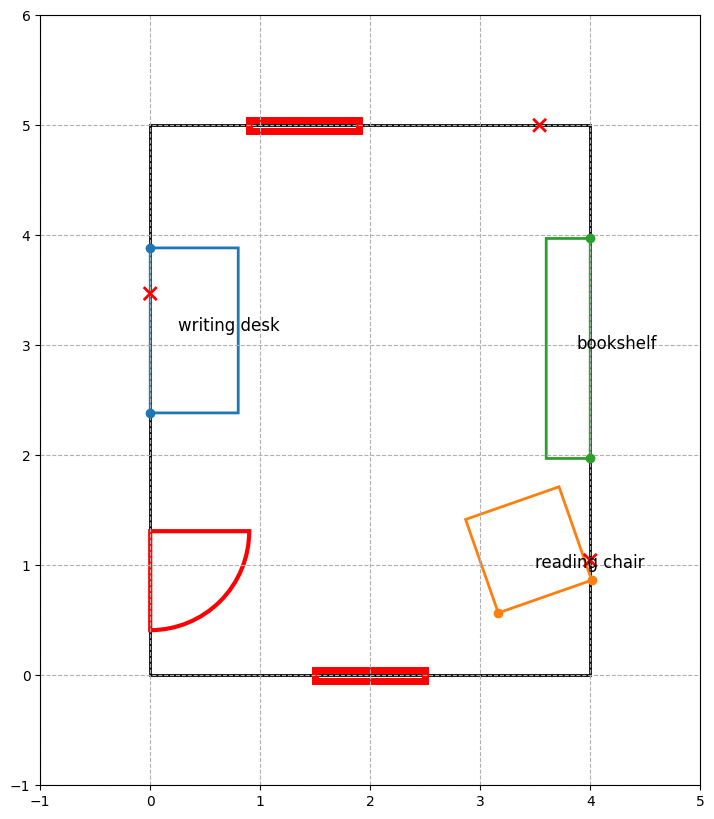

In [115]:
global_context = globals().copy()
local_context = {}
local_context2 = {}
exec(response1, global_context, local_context)

exec(primary_function, global_context, local_context) # define the very first optimizaton function 
## Now want to add in the first primary object
exec(response2) # add in the regions
exec(object_creations[0]) # add in the primary objecta
print("Adding in the primary objects: ", primary_objects)

options = {'maxiter': 200, 'ftol': 1e-6}
iters = 0
min_fun = np.Inf
room = local_context[room_name]
func = local_context['optimize_primary_objects']
best_res = None
second_res = None
bounds = Bounds([-1, -1, -np.inf] * len(room.moving_objects), [room.width + 1, room.length + 1, np.Inf] * len(room.moving_objects))
while min_fun > 1e-2 and iters < min(len(primary_objects)*100, 300):
    positions = np.zeros((len(room.moving_objects) - len(room.fm_indices)) * 3)
    for i in range(len(room.moving_objects) - len(room.fm_indices)):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
    res = minimize(func, positions, args = (room), method = 'SLSQP', options = options, bounds = bounds) 

    if iters%50 == 0: 
        print("Iteration:", iters)
        if not best_res:
            print("Cost: ", res.fun, no_overlap(res.x, room), in_bounds(res.x, room))
    iters += 1
    if res.fun < min_fun:
        if not no_overlap(res.x, room) > 0.3 and not in_bounds(res.x, room) > 1e-2:
            min_fun = res.fun
            best_res = res
            print("Iteration:", iters, ", New best result found. Cost: ", min_fun)
    if not second_res:
        second_res = res
    elif second_res and ((res.fun <= second_res.fun) and (in_bounds(res.x, room) <= in_bounds(second_res.x, room) or no_overlap(res.x, room) <= no_overlap(second_res.x, room))): 
        second_res = res

print(iters)
if not best_res: 
    best_res = second_res

for i in range(len(room.fm_indices), len(room.moving_objects)): 
    j = i - len(room.fm_indices)
    room.moving_objects[i].position = best_res.x[3*j:3*j + 3] 
room.draw() 

for i in range(num_regions):
    room.regions[i].x, room.regions[i].y = room.moving_objects[i].position[0], room.moving_objects[i].position[1]


In [116]:
print(primary_function)

def optimize_primary_objects(positions, room):
    output = 0
    # Constraints for Writing Desk
    output  += check_and_call('ind_accessible', positions, room, 0, ['front'])
    output  += check_and_call('ind_next_to_wall', positions, room, 0)
    output  += check_and_call('ind_close_to_fixed_object', positions, room, 0, 'socket')
    output  += check_and_call('ind_accessible', positions, room, 0, ['left', 'right'], min_dist=0.5)
    
    # Constraints for Reading Chair
    output  += check_and_call('ind_accessible', positions, room, 1, ['front', 'left'])
    output  += check_and_call('ind_in_corner', positions, room, 1)
    output  += check_and_call('ind_away_from_fixed_object', positions, room, 1, 'window')
    output  += check_and_call('ind_close_to_fixed_object', positions, room, 1, 'socket')
    output  += check_and_call('ind_accessible', positions, room, 1, ['front'], min_dist=0.5)
    # Constraints for Bookshelf
    output  += check_and_call('ind_accessible', positions, room, 

In [143]:
for i in range(len(secondary_functions)):
    print(secondary_functions[i])

def optimize_secondary_objects(positions, room):
    output = 0
    output  += check_and_call('ind_accessible', positions, room, 0, ['front'])
    output  += check_and_call('io_next_to', positions, room, 3, 0, side1='front', side2='front')
    output  += check_and_call('io_parallel', positions, room, 4, 0)
    output  += check_and_call('ind_in_region', positions, room, 3, 'desk')
    output  += check_and_call('ind_in_region', positions, room, 4, 'desk')
    output  += check_and_call('ind_next_to_wall', positions, room, 4)
    output  += check_and_call('ind_accessible', positions, room, 4, sides=['front'])
    output += in_bounds(positions, room)
    output += no_overlap(positions, room)
    output += aligned(positions, room)
    return output 
def optimize_secondary_objects(positions, room):
    output = 0
    output  += check_and_call('ind_accessible', positions, room, 0, ['front'])
    output  += check_and_call('ind_accessible', positions, room, 0, ['left', 'right'], min_dist=0.5)
  

In [145]:
def io_parallel(positions, room, object1_index, object2_index):
    """ The function p_parallel ensures that two objects have the same orientation in a room.
        That is, that they are parallel to each other. It does not handle distance, so if 
        proximity is important, please combine this function with p_near, or p_next to, or even p_between. 
        
        Args:
        positions: list of floats, x, y, theta values for all objects in the room
        room: rectangular Room object
        object1_index: int, index of object1 in the room
        object2_index: int, index of object2 in  roomthe
    """
    _, _, theta1 = get_position(positions, room, object1_index)
    _, _, theta2 = get_position(positions, room, object2_index)
     
    return ((theta1%(2*np.pi)) - (theta2%(2*np.pi)))**2  

In [173]:
def io_perp(positions, room, object1_index, object2_index, center_object_index = None):
    """ The function p_perp ensures that two objects are aligned in a room perpendicularly. 
        If center is given, the objects will be aligned about that point. For example, 
        a sofa and chair might be aligned perpendicularly about a coffee table or a side table. Or a chair at the head of the table 
        might be aligned perpendicularly with the chairs closest to it on the sides of the table. 

        Args:
        positions: list of floats, x, y, theta values for all objects in the room
        room: rectangular Room object
        object1_index: int, index of object1 in the room
        object2_index: int, index of object2 in the room
        center_object_index: int, index of object in room.moving_objects to be used as the pivot for the alignment (e.g. a coffee table or a table)
    """

    val = 0.0
    obj1, obj2 = room.moving_objects[object1_index], room.moving_objects[object2_index]
    x1, y1, theta1 = get_position(positions, room, object1_index)
    x2, y2, theta2 = get_position(positions, room, object2_index)

    cs1 = np.array(corners(x1, y1, theta1, obj1.width, obj1.length))# TL, TR, BR, BL
    cs2 = np.array(corners(x2, y2, theta2, obj2.width, obj2.length))

    mid_front1 = (cs1[2, :] + cs1[3, :])/2
    mid_front2 = (cs2[2, :] + cs2[3, :])/2

    dir1 = (cs1[3, :] - cs1[0, :])/np.linalg.norm(cs1[3, :] - cs1[0, :])
    dir2 = (cs2[3, :] - cs2[0, :])/np.linalg.norm(cs2[3, :] - cs2[0, :])

    ### Find t1, and t2 (intersection line lengths - want there to be a right angled triangle between each object)
    BA = mid_front2 - mid_front1
    t1 = np.dot(np.array([dir2[1], -dir2[0]]), BA) / np.dot(np.array([dir2[1], -dir2[0]]), dir1)
    t2 = np.dot(np.array([dir1[1], -dir1[0]]), BA) / np.dot(np.array([dir2[1], -dir2[0]]), dir1)
    
    if not center_object_index:
        lim = np.sqrt((0.8*obj1.width)**2 + (0.8*obj2.width)**2)
        val += (np.linalg.norm(BA) - np.sqrt(t1**2 + t2**2))**2 
        val += min(0.0, t1)**2 + min(0.0, t2)**2 # t1 and t2 should be bigger than 0 
        val += min(0.0, lim - np.sqrt(t1**2+ t2**2))**2 # t1 and t2 should not be too big
        val += ((max((theta1%(2*np.pi)), (theta2%(2*np.pi))) - min((theta1%(2*np.pi)), (theta2%(2*np.pi)))) - np.pi/2)**2 ## thetas should be pi/2 apart
    else: 
        center_obj = room.moving_objects[center_object_index]
        lim = np.sqrt((center_obj.width)**2 + (center_obj.length)**2)
        x3, y3, theta3 = positions[3*center_object_index:3*center_object_index + 3]
        val += min(0.0, t1)**2 + min(0.0, t2)**2 # t1 and t2 should be bigger than 0 
        val += (np.linalg.norm(BA) - np.sqrt((t1**2 + t2**2)))**2 ## mid_front1, mid_front2, and intersection point should make a right angled triangle 
        C = np.array([x1, y1]) + t1 * dir1 
        val += (C[0] - x3)**2 + (C[1] - y3)**2 # C should be the center of the center object
        val += min(0.0, lim - np.sqrt(t1**2+ t2**2))**2 # t1 and t2 should not be too big
        val += ((max((theta1%(2*np.pi)), (theta2%(2*np.pi))) - min((theta1%(2*np.pi)), (theta2%(2*np.pi)))) - np.pi/2)**2 ## thetas should be pi/2 apart
    return val

Adding in the secondary objects:  ['desk chair', 'filing cabinet']
Iteration: 0
Cost:  4.112032084738389 0.13656819500427078 0.0018368079935224527
Iteration 1 , New best result found. Cost:  4.112032084738389 overlap:  0.13656819500427078 bounds:  0.0018368079935224527
Iteration 2 , New best result found. Cost:  4.112032082402489 overlap:  0.1365487865401591 bounds:  0.0018368079935224527
Iteration 5 , New best result found. Cost:  4.112031881914019 overlap:  0.13654607293820242 bounds:  0.0018368079935224527
Iteration 9 , New best result found. Cost:  4.112031881775823 overlap:  0.13655935215022708 bounds:  0.0018368079935224527
Iteration 19 , New best result found. Cost:  4.112031881731359 overlap:  0.136551835822196 bounds:  0.0018368079935224527
Iteration 47 , New best result found. Cost:  4.112031881667563 overlap:  0.1365507432883888 bounds:  0.0018368079935224527
Iteration: 50


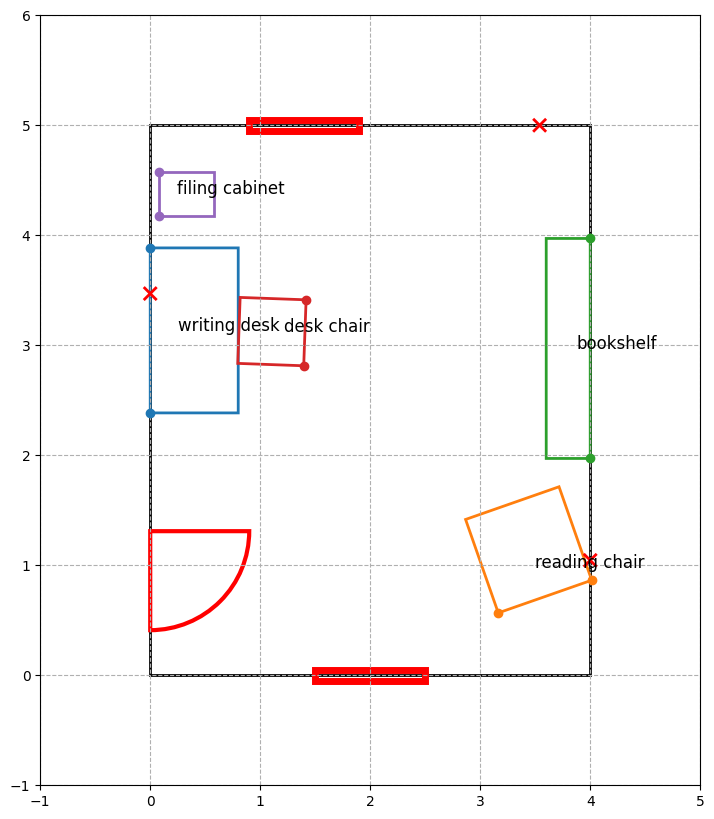

Adding in the secondary objects:  ['side table', 'floor lamp']
Iteration: 0
Cost:  10.854311235715121 3.754135806283485 0.0018368079935224527
Iteration 3 , New best result found. Cost:  6.7212228800011165 overlap:  0.13661450201492698 bounds:  0.0018368079935224527
Iteration 8 , New best result found. Cost:  6.243555110886555 overlap:  0.13663662694990988 bounds:  0.0018368079935224527
Iteration 30 , New best result found. Cost:  6.243392025434672 overlap:  0.13662737960827873 bounds:  0.0018368079935224527
Iteration: 50


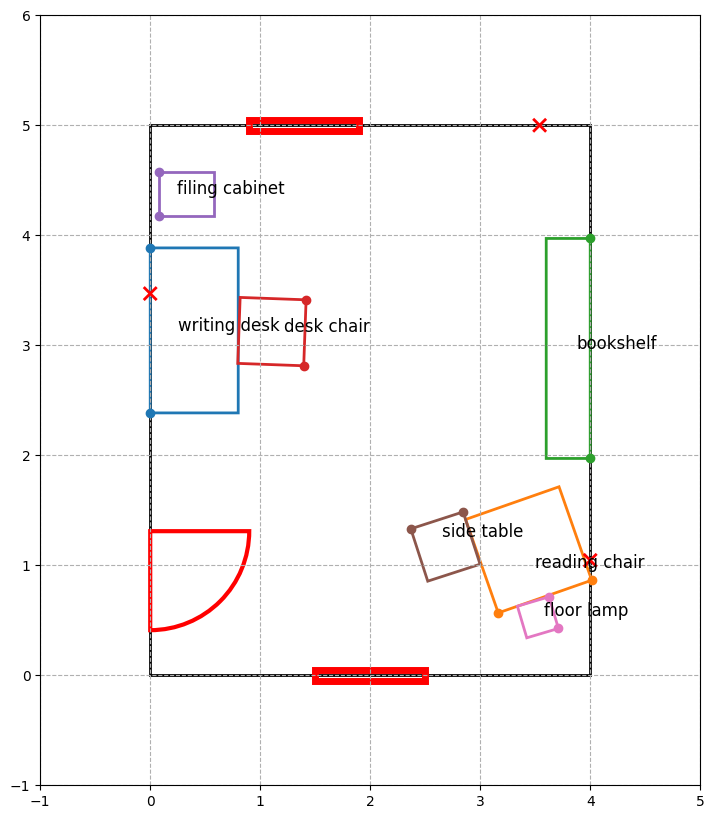

Adding in the secondary objects:  ['additional bookshelf', 'potted plant']
Iteration: 0
Cost:  23.99189012929905 0.13662737960827873 0.5056309917801194
Iteration 3 , New best result found. Cost:  8.720673346217087 overlap:  0.13662737960827873 bounds:  0.0018749099545410741
Iteration 6 , New best result found. Cost:  8.536947997053304 overlap:  0.13662737960827873 bounds:  0.0018368079935224683
Iteration: 50
Iteration 54 , New best result found. Cost:  8.53694799394329 overlap:  0.13662737960827873 bounds:  0.0018368079935224527
Iteration 56 , New best result found. Cost:  8.536947989465707 overlap:  0.13662737960827873 bounds:  0.0018368079935224527
Iteration 70 , New best result found. Cost:  8.536947986435399 overlap:  0.13662737960827873 bounds:  0.0018368079935224527


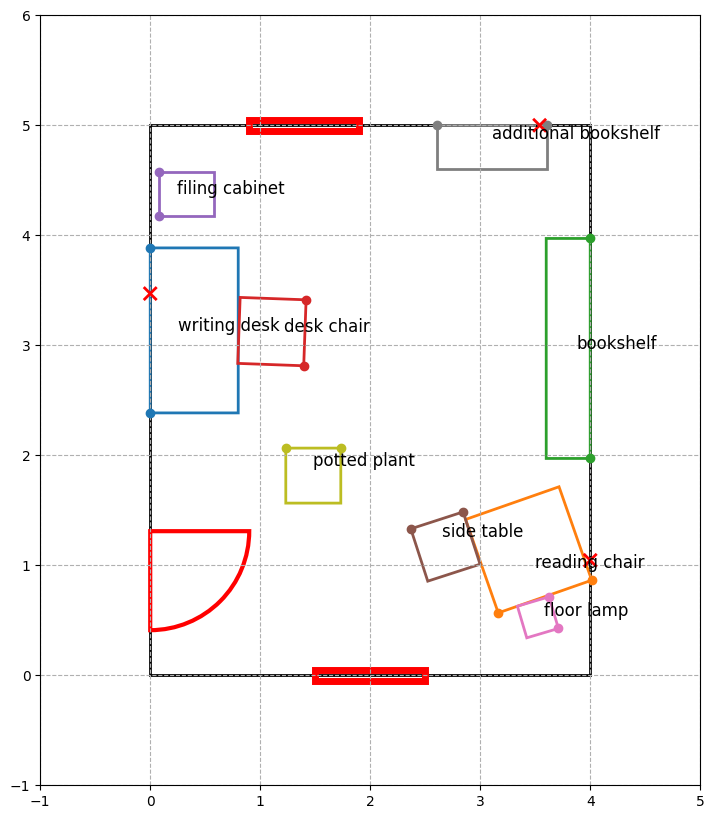

In [183]:
room.moving_objects = room.moving_objects[:num_primary_objects]
room.fm_indices = [i for i in range(num_primary_objects)]
room.tertiary_objects = []
options = {'maxiter': 200, 'ftol': 1e-8}

for region in range(num_regions):
    exec(object_creations[region + 1]) # add in the secondary objects for the region
    exec(secondary_functions[region], global_context, local_context) # define the optimization function for the secondary objects
    room = local_context[room_name]
    func = local_context['optimize_secondary_objects']
    
    print("Adding in the secondary objects: ", [room.moving_objects[i].name for i in objects_per_region[region]][1:])

    num = len(room.moving_objects) - len(room.fm_indices)
    bounds = Bounds([-1] * 3 * num, [room.width + 1, room.length + 1, np.Inf] * num)
    iters = 0
    min_fun = np.Inf
    best_res2 = None
    second_res = None
    while (min_fun > 1e-2 and best_res2 is None and iters < 400) or (best_res2 and iters < min(num*50, 300)):
        #if iters == 399: 
            #print("Iteration 150, no solution found, putting the objects outside of the room.")
            #best_res2 = res
            #best_res2.x = np.array([room.width + 3, room.length + 3, 0] * num)
        positions = np.zeros(3*num)
        for i in range(num):
            positions[3*i] = np.random.uniform(0, room.width)
            positions[3*i + 1] = np.random.uniform(0, room.length)
            positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
        res = minimize(func, positions, args = (room), method = 'SLSQP', options = options, bounds = bounds)

        if iters%50 == 0:
            print("Iteration:", iters)
            if not best_res2:
                print("Cost: ", res.fun, no_overlap(res.x, room), in_bounds(res.x, room))
        iters += 1
        if res.fun < min_fun:
            if not no_overlap(res.x, room) > 0.4 and not in_bounds(res.x, room) > 0.1:
                min_fun = res.fun 
                best_res2 = res
                print("Iteration", iters, ", New best result found. Cost: ", min_fun, "overlap: ", no_overlap(res.x, room), "bounds: ", in_bounds(res.x, room))
        if not second_res:
            second_res = res
        elif second_res and ((res.fun <= second_res.fun) and (in_bounds(res.x, room) <= in_bounds(second_res.x, room) or no_overlap(res.x, room) <= no_overlap(second_res.x, room))): 
            second_res = res
    
    if not best_res2: 
        best_res2 = second_res
  
    for i in range(len(room.fm_indices), len(room.moving_objects)): 
        j = i - len(room.fm_indices)
        room.moving_objects[i].position = best_res2.x[3*j:3*j + 3] 

    room.regions[region].x = np.mean([i.position[0] for i in room.moving_objects if i.region == list_region_names[region]])
    room.regions[region].y = np.mean([i.position[1] for i in room.moving_objects if i.region == list_region_names[region]])

    room.draw() 
    plt.show()
    room.fm_indices += [i for i in range(len(room.fm_indices), len(room.moving_objects))]


In [184]:
print(response7)
print(response8)

create_tertiary_object(local_context[room_name], 'laptop', 0.4, 0.3, 'table', 0)
create_tertiary_object(local_context[room_name], 'desk_lamp', 0.2, 0.2, 'table', 1)
create_tertiary_object(local_context[room_name], 'throw_pillow', 0.45, 0.45, 'table', 2)
create_tertiary_object(local_context[room_name], 'table_lamp', 0.25, 0.25, 'table', 3)
create_tertiary_object(local_context[room_name], 'artwork', 1.0, 0.1, 'wall', 4)
create_tertiary_object(local_context[room_name], 'bookend', 0.2, 0.1, 'table', 5)
create_tertiary_object(local_context[room_name], 'chandelier', 1.0, 1.0, 'ceiling', 6)
create_tertiary_object(local_context[room_name], 'area_rug', 2.0, 3.0, 'floor', 7)
def optimize_tertiary_objects(positions, room):
    output = 0
    output  += check_and_call('on_top_central', positions, room, 0, 0)
    output  += check_and_call('on_top_corner', positions, room, 1, 0, corner='tl')
    output  += check_and_call('on_top_central', positions, room, 2, 1)
    output  += check_and_call('on_top_

Iteration 0 , New best result found. Cost:  1.3775792901143353
Iteration 1 , New best result found. Cost:  0.5284277743222959
Iteration 9 , New best result found. Cost:  0.5284277742967562
Time taken:  7273.716768026352


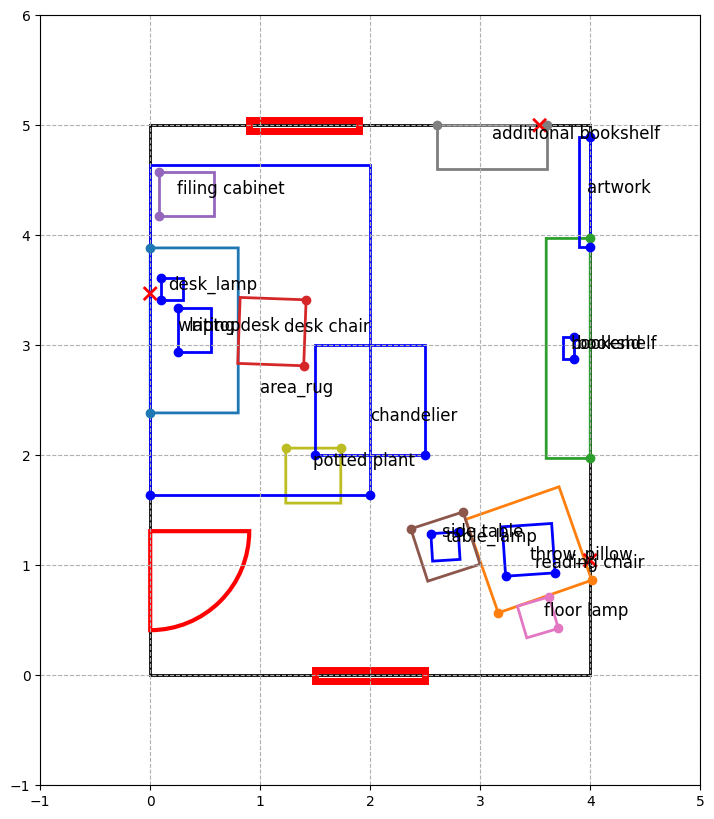

In [185]:
from Tertiary import *
room.tertiary_objects = []
exec(response7)
exec(response8, global_context, local_context)

positions = np.zeros(3*len(room.tertiary_objects))
optimize_tertiary_objects = local_context['optimize_tertiary_objects']
room = local_context[room_name]
options = {'maxiter': 500, 'ftol': 1e-10}
bounds =Bounds([-1, -1, -np.inf] * len(room.tertiary_objects), [room.width + 1, room.length + 1, np.Inf] * len(room.tertiary_objects))
best_res = None
best_fun = np.Inf
for its in range(3 * len(room.tertiary_objects)): 
    for i in range(len(room.tertiary_objects)):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 

    res = minimize(optimize_tertiary_objects, positions, args = (room), method = 'SLSQP', options = options, bounds = bounds)
    if res.fun < best_fun and res.fun > 0:
        print("Iteration", its, ", New best result found. Cost: ", res.fun)
        best_res = res
        best_fun = res.fun

for i in range(len(room.tertiary_objects)): 
    room.tertiary_objects[i].position = best_res.x[3*i:3*i + 3]

room.draw()
end_time = time.time()
elapsed_time = end_time - start_time
print("Time taken: ", elapsed_time)

In [186]:
for object in room.moving_objects: 
    print(object.name, object.position, object.width, object.length)

print(" ")
for object in room.fixed_objects: 
    print(object.name, object.position, object.width, object.length)

print(" ")
for object in room.tertiary_objects: 
    print(object.name, object.position, object.width, object.length)


writing desk [ 0.39999933  3.13517911 -1.57079459] 1.5 0.8
reading chair [  3.4402223    1.14037645 -18.51311056] 0.9 0.9
bookshelf [ 3.79999577  2.97111925 -4.7123931 ] 2 0.4
desk chair [1.10643036 3.12433009 1.53461905] 0.6 0.6
filing cabinet [0.33356359 4.37647329 4.71238885] 0.4 0.5
side table [2.68381854 1.17040405 3.45469148] 0.5 0.5
floor lamp [3.52442046 0.52684272 1.85895362] 0.3 0.3
additional bookshelf [3.11055076 4.8        3.14159266] 1 0.4
potted plant [1.48244805 1.81514986 3.14156827] 0.5 0.5
 
window (1.4, 5, 3.141592653589793) 1 0.1
window (2.0, 0, 0) 1 0.1
door (0, 1.31, 4.71238898038469) 0.9 0.1
socket (4, 1.045, 1.5707963267948966) 0.15 0.1
socket (3.5400000000000005, 5, 3.141592653589793) 0.15 0.1
socket (0, 3.4699999999999998, 4.71238898038469) 0.15 0.1
 
laptop [ 0.39999968  3.1351786  42.41150138] 0.4 0.3
desk_lamp [  0.19999857   3.51017874 -14.13716656] 0.2 0.2
throw_pillow [  3.44022163   1.14037641 -69.0470823 ] 0.45 0.45
table_lamp [ 2.68381853  1.17040404

In [187]:
import string
import random

dictionary = {}

ints = [i for i in range(20)]

dictionary['prompt'] = scene_descriptor
dictionary['room_width'] = room.width
dictionary['room_length'] = room.length

for object in room.moving_objects: 
    if object.name in dictionary.keys(): 
        object_name = object.name + str(ints[0])
        ints = ints[1:]
    else:
        object_name = object.name
    dictionary[object_name] = {}
    dictionary[object_name]['position'] = object.position
    dictionary[object_name]['width'] = object.width
    dictionary[object_name]['length'] = object.length

for object in room.fixed_objects:
    if object.name in dictionary.keys():
        object_name = object.name + str(ints[0])
        ints = ints[1:]
    else:
        object_name = object.name
    dictionary[object_name] = {}
    dictionary[object_name]['position'] = object.position
    dictionary[object_name]['width'] = object.width
    dictionary[object_name]['length'] = object.length

for object in room.tertiary_objects:

    if object.name in dictionary.keys():
        object_name = object.name + str(ints[0])
        ints = ints[1:]
    else:
        object_name = object.name
    dictionary[object_name] = {}
    dictionary[object_name]['position'] = object.position
    dictionary[object_name]['width'] = object.width
    dictionary[object_name]['length'] = object.length

dictionary['style'] = STYLEoutput.choices[0].message.content
res = ''.join(random.choices(string.ascii_letters,
                             k=3))
## Save the dictionary to a text file
file_path =  "/Users/gabriellelittlefair/Documents/GitHub/MSc Project/Result_txt/" + res + ".txt"
with open(file_path, 'w') as file:
    for key, value in dictionary.items():
        file.write(f"{key}: {value}\n")

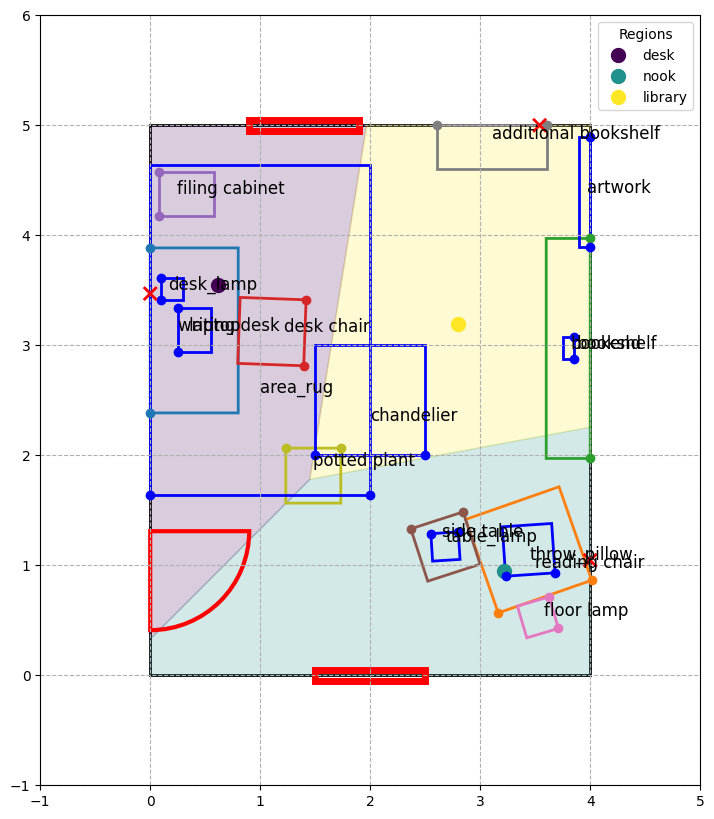

In [188]:
room.draw(draw_regions = True)

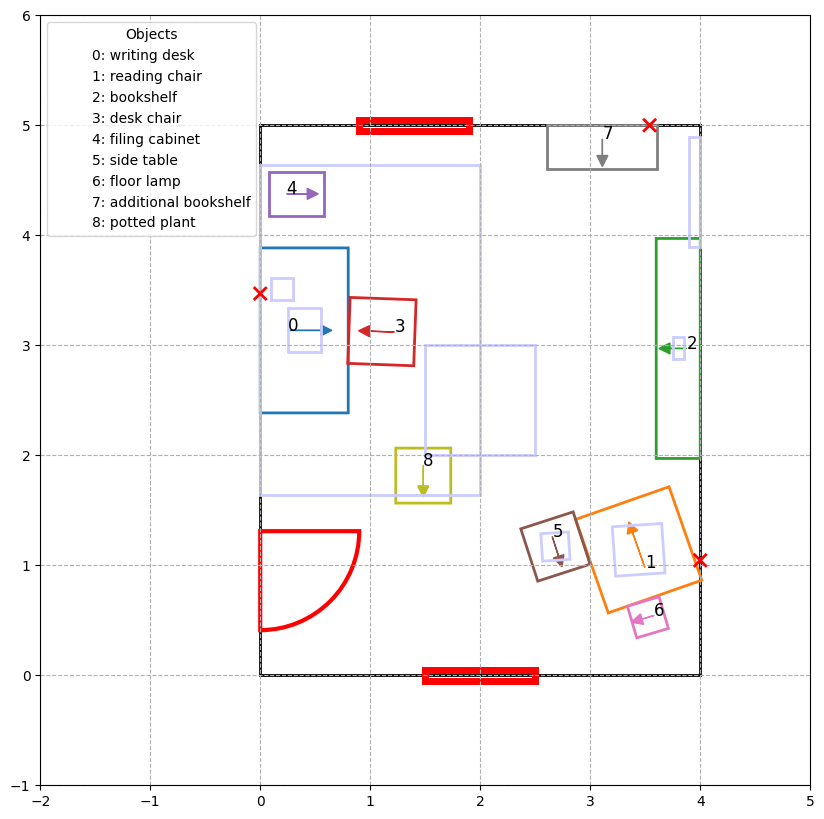

In [189]:
room.draw(level = 0, arrows = True, key = True)

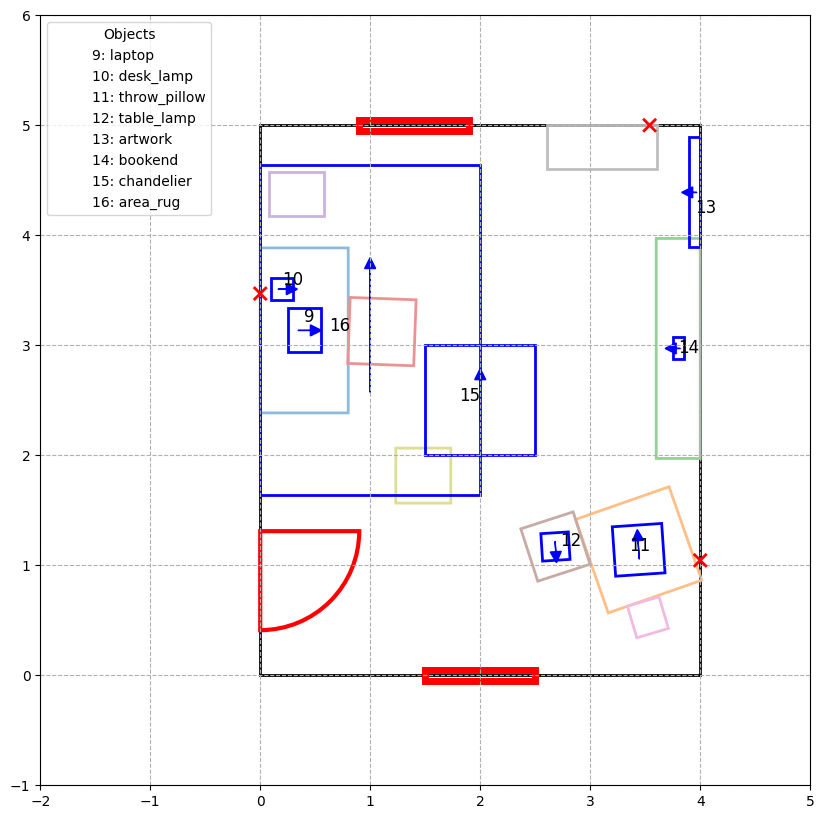

In [190]:
room.draw(level = 1, arrows = True, key = True)

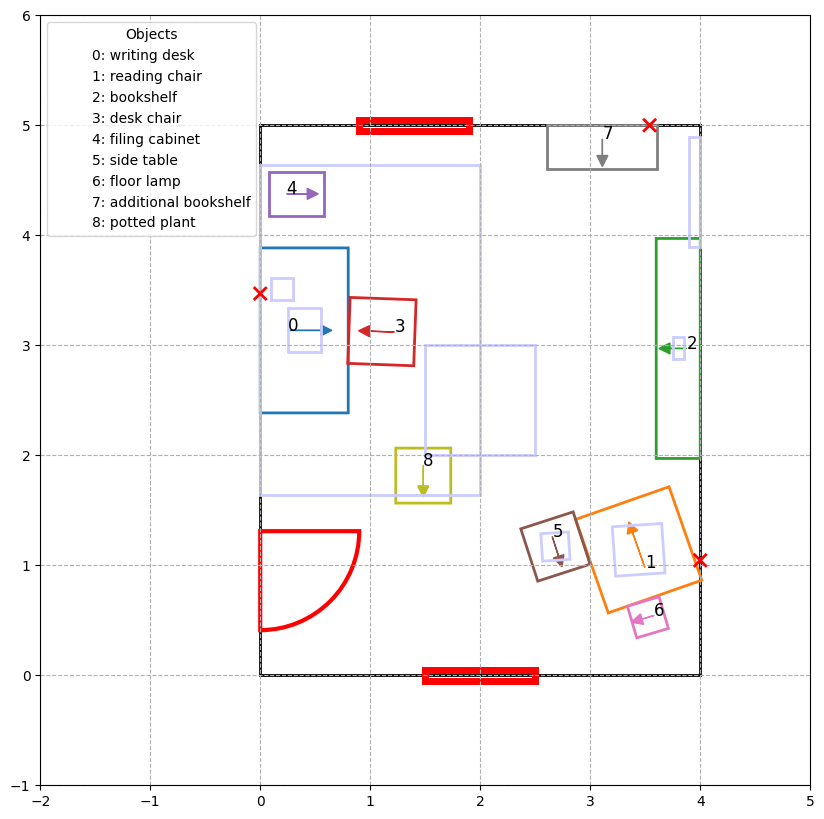

In [191]:
room.draw(level = 0, arrows = True, key = True)

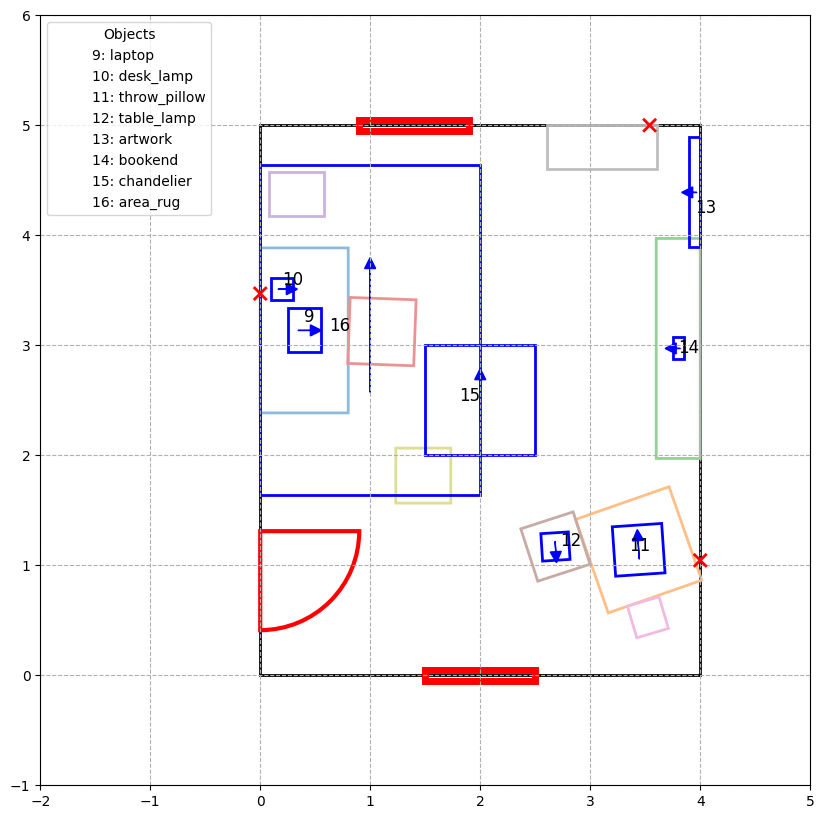

In [192]:
room.draw(level = 1, arrows = True, key = True)

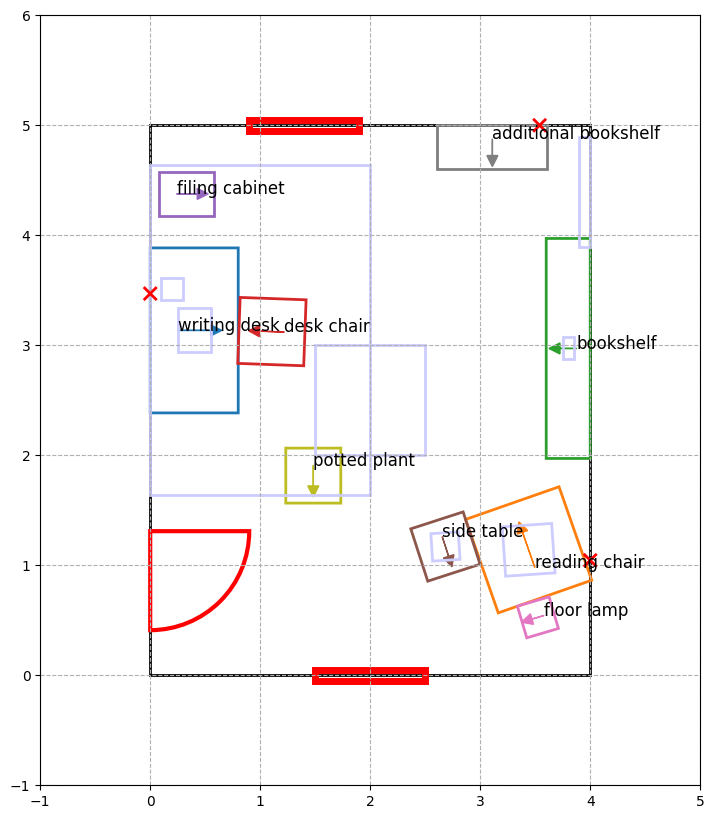

In [193]:
room.draw(level = 0, arrows = True)

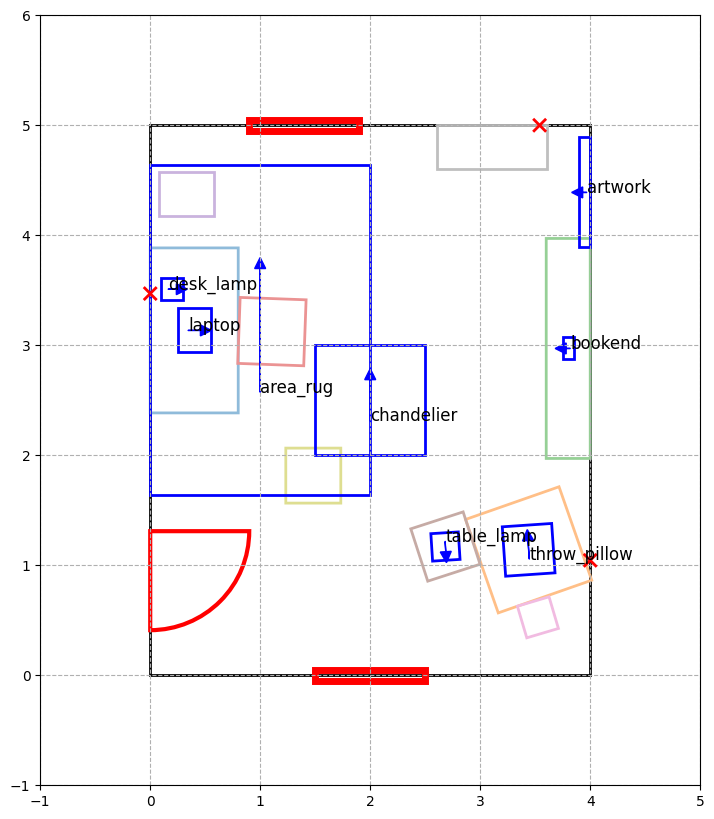

In [194]:
room.draw(level = 1, arrows = True)

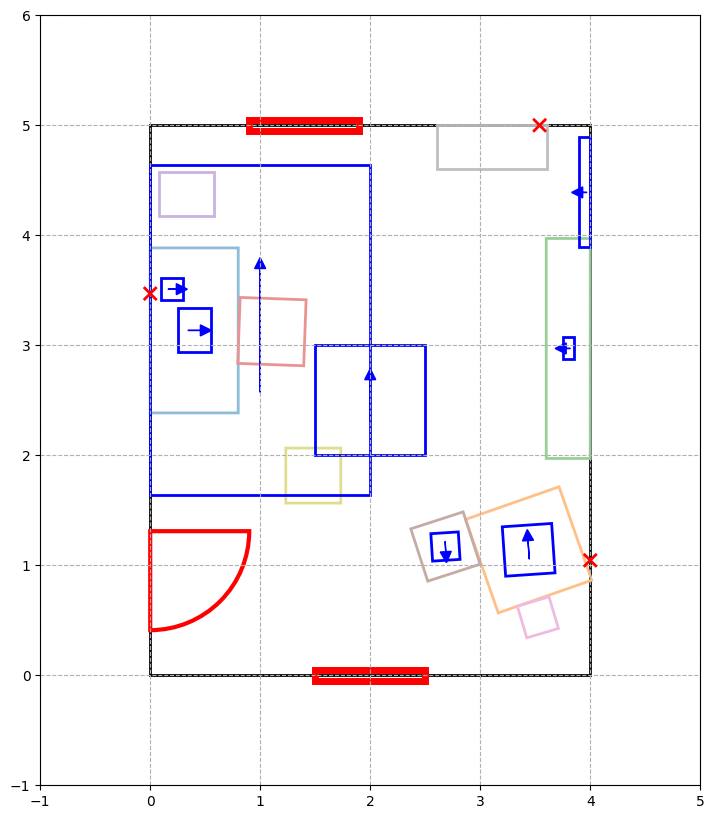

In [3]:
room = create_room(4, 5)
create_fixed_object(room, 'window', 1, 0.1, 'north', 0.3)
create_fixed_object(room, 'window', 1, 0.1, 'south', 0.5)
create_fixed_object(room, 'door', 0.9, 0.1, 'west', 0.1)
create_fixed_object(room, 'socket', 0.15, 0.1, 'east', 0.2)
create_fixed_object(room, 'socket', 0.15, 0.1, 'north', 0.9)
create_fixed_object(room, 'socket', 0.15, 0.1, 'west', 0.7)

room.moving_objects = [Object('writing desk', 1.5, 0.8, position = (0.3999999993, 3.13517911, -1.57079459))]
room.moving_objects += [Object('reading chair', 0.9, 0.9, position = (3.4402223, 1.14037645, -18.51311056))]
room.moving_objects += [Object('bookshelf', 2, 0.4, position = (3.79999577, 2.97111925, -4.7123931))]
room.moving_objects += [Object('desk chair', 0.6, 0.6, position = (1.10643036, 3.12433009, 1.53461905))]
room.moving_objects += [Object('filing cabinet', 0.4, 0.5, position = (0.33356359, 4.37647329, 4.71238885))]
room.moving_objects += [Object('side table', 0.5, 0.5, position = (2.68381854, 1.17040405, 3.45469148))]
room.moving_objects += [Object('floor lamp', 0.3, 0.3, position = (3.52442046, 0.52684272, 1.85895362))]
room.moving_objects += [Object('additional bookshelf', 1, 0.4, position = (3.11055076, 4.8, 3.14159266))]
room.moving_objects += [Object('potted plant', 0.5, 0.5, position = (1.48244805, 1.81514986, 3.14156827))]

room.tertiary_objects = [Object('laptop', 0.4, 0.3, position = (0.39999968, 3.1351786, 42.41150138))]
room.tertiary_objects += [Object('desk lamp', 0.2, 0.2, position = (0.19999857, 3.51017874, -14.13716656))]
room.tertiary_objects += [Object('throw pillow', 0.45, 0.45, position = (3.44022163, 1.14037641, -69.0470823))]
room.tertiary_objects += [Object('table lamp', 0.25, 0.25, position = (2.68381853, 1.17040404, 34.62067476))]
room.tertiary_objects += [Object('artwork', 1, 0.1, position = (3.95, 4.38958825, 1.57079632))]
room.tertiary_objects += [Object('bookend', 0.2, 0.1, position = (3.79999595, 2.97111924, -36.12831604))]
room.tertiary_objects += [Object('chandelier', 1, 1, position = (2, 2.49999999, 18.84955636))]
room.tertiary_objects += [Object('area rug', 2, 3, position = (0.99940061, 3.13517908, 157.07963268))]

room.draw(level = 1, arrows = True)

In [160]:
# def path_points(room, plot = False): 

#     vor = medial_axis(room)
#     vor_points = vor.points
#     all_points = []
#     weights = []

#     c_inds = find_corner_points(vor_points)
#     corner_points = vor_points[c_inds]

#     if plot: 
#         fig, axes = plt.subplots()
#     for i in range(len(vor.ridge_vertices)): 
#         mid_points = []
#         edge = vor.ridge_vertices[i]
#         if np.linalg.norm(vor.vertices[edge[0]] - vor.vertices[edge[1]]) > 0.1: 
#             points = np.linspace(vor.vertices[edge[0]], vor.vertices[edge[1]], 25)
#             verts = [i.tolist() for i in vor.vertices]
#             vor.vertices = np.array(verts + points.tolist())
#             mid_points = points

#         min_index = np.argmin([vor.vertices[edge[0]][0], vor.vertices[edge[1]][0]])
#         other_index = 1 - min_index
#         direction = vor.vertices[edge[other_index]] - vor.vertices[edge[min_index]]
#         direction = direction / np.linalg.norm(direction)
#         perpendicular_direction = np.array([direction[1], -direction[0]])
#         perpendicular_direction = perpendicular_direction / np.linalg.norm(perpendicular_direction)

#         ws = np.array([1, 2, 3, 5, 3, 2, 1])
#         if len(mid_points) > 0: 
#             for point in mid_points: 
#                 mid_point = point
#                 dists = np.linalg.norm(corner_points - mid_point, axis = 1)
#                 if np.any(dists < 0.25): 
#                     continue
#                 x = np.linspace(mid_point[0] - 0.3 * perpendicular_direction[0], mid_point[0] + 0.3 * perpendicular_direction[0], 7)
#                 y = np.linspace(mid_point[1] - 0.3 * perpendicular_direction[1], mid_point[1] + 0.3 * perpendicular_direction[1], 7)
#                 for i in range(7): 
#                     all_points.append([x[i], y[i]])
#                 if plot: 
#                     axes.scatter(x, y)
#         else: 
            
#             mid_point = (vor.vertices[edge[0]] + vor.vertices[edge[1]]) / 2
#             dists = np.linalg.norm(corner_points - mid_point, axis = 1)
#             if np.any(dists < 0.25): 
#                 continue

#             val = False
#             for point in vor.points: 
#                 if np.linalg.norm(point - mid_point) < 0: 
#                     val = True
#                     break
#             if val: 
#                 continue

#             x = np.linspace(mid_point[0] - 0.3 * perpendicular_direction[0], mid_point[0] + 0.3 * perpendicular_direction[0], 7)
#             y = np.linspace(mid_point[1] - 0.3 * perpendicular_direction[1], mid_point[1] + 0.3 * perpendicular_direction[1], 7)
#             for xi, yi in zip(x, y):
#                 all_points.append([xi, yi])
        
            
#     all_points = np.array(all_points)
#     weights = ws.tolist() * (all_points.shape[0]//7)
#     if plot: 
#         axes.scatter(all_points[:, 0], all_points[:, 1], c = weights)
#         voronoi_plot_2d(vor, ax = axes, show_points=True, show_vertices=False, line_colors='gray')

#     return all_points, weights

In [161]:
# def medial_axis(room, draw = False):

#     final_points = []
    
#     # Draw the room
#     rect = patches.Rectangle((0, 0), room.width, room.length, linewidth=2, edgecolor='black', facecolor='none', label='_nolegend_')

#     points = []
#     cs = rect.get_corners()
#     num_points = int(np.ceil(2 * (5 * room.width + 5 * room.length)))
#     for i in range(num_points):
#         points.append(cs[0] + (cs[1] - cs[0]) * i / num_points)  # Bottom side
#         points.append(cs[1] + (cs[2] - cs[1]) * i / num_points)  # Right side
#         points.append(cs[2] + (cs[3] - cs[2]) * i / num_points)  # Top side
#         points.append(cs[3] + (cs[0] - cs[3]) * i / num_points)  # Left side
#     final_points.append(points)

#     rug_names = ['rug', 'mat', 'Rug', 'Mat', 'RUG', 'MAT', 'carpet', 'Carpet']
#     if room.moving_objects:
#         for obj in room.moving_objects:
#             rug = False
#             for name in rug_names: 
#                 if name in obj.name:
#                     rug = True
#                     break
#             if rug: 
#                 continue 
#             cs_tup = obj.corners()
#             cs = [np.array(i) for i in cs_tup]
#             points = []
#             num_points = int(np.ceil(2 * (5 * obj.width + 5 * obj.length)))
#             for i in range(num_points):
#                 points.append(cs[0] + (cs[1] - cs[0]) * i / num_points)
#                 points.append(cs[1] + (cs[2] - cs[1]) * i / num_points)
#                 points.append(cs[2] + (cs[3] - cs[2]) * i / num_points)
#                 points.append(cs[3] + (cs[0] - cs[3]) * i / num_points)
            
#             points = np.array(points)
#             final_points.append(points)

#     if room.fixed_objects:
#         for obj in room.fixed_objects:
#             if obj.name == 'door':

#                 wedge = patches.Wedge(center=obj.position[:2], r=obj.width, 
#                                         theta1=np.rad2deg(obj.position[2]), theta2=np.rad2deg(obj.position[2]) + 90, linewidth=3, edgecolor='r', facecolor='none')
                
#                 points = wedge.get_path().vertices
#                 if obj.position[2] == 0:
#                     points = [i for i in points if np.isclose(i[1], 0)]
#                     points = np.unique(points, axis = 0)
#                     min_x, max_x = sorted([i[0] for i in points])
#                     crit = lambda x: np.isclose(x[1], 0) and (min_x < x[0]) and (x[0] < max_x)
#                     crit2 = lambda x: np.isclose(x[1], 0)
#                 elif obj.position[2] == np.pi/2:
#                     points = [i for i in points if np.isclose(i[0], room.width)]
#                     points = np.unique(points, axis = 0)
#                     min_y, max_y = sorted([i[1] for i in points])
#                     crit = lambda x: np.isclose(x[0], room.width) and( min_y < x[1]) and (x[1] < max_y ) 
#                     crit2 = lambda x: np.isclose(x[0], room.width) 
#                 elif obj.position[2] == np.pi:
#                     points = [i for i in points if np.isclose(i[1], room.length)]
#                     points = np.unique(points, axis = 0)
#                     min_x, max_x = sorted([i[0] for i in points])
#                     crit = lambda x: np.isclose(x[1], room.length) and (min_x < x[0]) and (x[0] < max_x)
#                     crit2 = lambda x: np.isclose(x[1], room.length)
#                 elif obj.position[2] == 3*np.pi/2:
#                     points = [i for i in points if np.isclose(i[0], 0)]
#                     points = np.unique(points, axis = 0)
#                     min_y, max_y = sorted([i[1] for i in points])
#                     crit = lambda x: np.isclose(x[0], 0) and (min_y < x[1]) and (x[1] < max_y ) 
#                     crit2 = lambda x: np.isclose(x[0], 0)
#                 final_points.append(points)

#     final_points = np.concatenate(final_points)

#     door_points = []
#     for point in final_points:
#         if crit(point):
#             door_points += [point]
#             final_points = np.delete(final_points, np.where(np.all(final_points == point, axis = 1)), axis = 0)
#     vor = Voronoi(final_points)

#     new_edges = []
#     new_ridge_points = []
#     new_regions = []
#     ## find the door ridge 
#     ridge_points = vor.ridge_points
#     for i in range(len(ridge_points)): 
#         edge = ridge_points[i]
#         p1, p2 = vor.points[edge]
#         if crit2(p1) and crit2(p2) and np.linalg.norm(p1 - p2) > 0.4:
#             new_edges.append(vor.ridge_vertices[i])
#             new_ridge_points.append(vor.ridge_points[i])

#     for i in range(len(vor.ridge_vertices)): 
#         edge = vor.ridge_vertices[i]
#         remove = False
#         p1 = vor.vertices[edge[0]]
#         p2 = vor.vertices[edge[1]]
#         if (edge[0] == -1 or edge[1] == -1):
#             continue
#         if p1[0] < 0 or p2[0] < 0 or p1[1] < 0 or p2[1] < 0:
#             continue
#         if p1[0] > room.width or p1[1] > room.length or p2[0] > room.width or p2[1] > room.length:
#             continue
#         for obj in room.moving_objects:
#             rug = False
#             for name in rug_names: 
#                 if name in obj.name:
#                     rug = True
#                     break
#             if rug:
#                 continue
#             poly = Polygon(obj.corners())
#             if any([poly.contains(Point(vor.vertices[v])) for v in edge]):
#                 remove = True
#                 break

#         if remove: 
#             continue
        

#         regions = [j for j in range(len(vor.regions)) if edge[0] in vor.regions[j] and edge[1] in vor.regions[j]]
#         region_vs = [[], []]
#         for j in range(2): 
#             region_vs[j] = [v for v in vor.regions[regions[j]] if v != edge[0] and v != edge[1]]

#         dists = []
#         for j in range(len(region_vs[0])): 
#             for k in range(len(region_vs[1])):
#                 dists.append(np.linalg.norm(vor.vertices[region_vs[0][j]] - vor.vertices[region_vs[1][k]]))
#         if np.any(np.array(dists) < 1e-8): 
#             continue 
#         else: 
#             new_edges.append(edge)  
#             new_ridge_points.append(vor.ridge_points[i])  
    

    

#     new_vor = Voronoi(final_points)
#     new_vor.vertices = vor.vertices
#     new_vor.regions = vor.regions
#     new_vor.ridge_vertices = new_edges
#     new_vor.ridge_points = new_ridge_points

#     if draw:
#         fig, ax = plt.subplots(figsize = (10, 10))
#         voronoi_plot_2d(new_vor, ax=ax, show_points=True, show_vertices=False, line_colors='gray')

#     return new_vor


In [162]:
# room.draw(draw_regions=True)
# vor = medial_axis(room)
# voronoi_plot_2d(vor, show_points=True, show_vertices=False, line_colors='gray')
# print(len(vor.regions))

In [163]:
# def cost(positions, room, points, weights): 

#     intersection = 0
#     rug_names = ['rug', 'mat', 'Rug', 'Mat', 'RUG', 'MAT', 'carpet', 'Carpet']
#     for i in range(len(room.moving_objects)): 
#         rug = False
#         for name in rug_names: 
#             if name in room.moving_objects[i].name:
#                 rug = True
#                 break
#         if rug: 
#             continue 
#         x, y, theta = get_position(positions, room, i)
#         cs = corners(x, y, theta, room.moving_objects[i].width, room.moving_objects[i].length)
#         poly = Polygon(cs)
#         for j in range(points.shape[0]): 
#             if poly.contains(Point(points[j, :])): 
#                 intersection += weights[j]*poly.exterior.distance(Point(points[j, :]))**2

#     return intersection




In [164]:
# #from Class_Structures import medial_axis, cost, path_points, Room

# room.draw()

# room.fm_indices = []
# points, weights = path_points(room)
# draw_medial_axis(room, points, weights)
# vor = medial_axis(room)

# positions = np.zeros(len(room.moving_objects)*3)
# for i in range(len(room.moving_objects)): 
#     positions[3*i] = room.moving_objects[i].position[0]
#     positions[3*i + 1] = room.moving_objects[i].position[1]
#     positions[3*i + 2] = room.moving_objects[i].position[2]
    
# exec(final_function, global_context, local_context)
# final_func = local_context['optimize']

# def func(positions, room, points, weights):
#     return cost(positions, room, points, weights) + 50*in_bounds(positions, room) + 50*no_overlap(positions, room) #final_func(positions, room)

# options = {'maxiter': 50, 'disp': True}
# bounds = Bounds([-10] * 3 * len(room.moving_objects), [room.width + 10, room.length + 10, np.Inf] * len(room.moving_objects))
# res = minimize(func, positions, args = (room, points, weights), method = 'SLSQP', options = options, bounds = bounds)

# for i in range(len(room.moving_objects)):
#     room.moving_objects[i].position = [res.x[3*i], res.x[3*i + 1], res.x[3*i + 2]]

# room.draw()